In [81]:
# Using Python 3.13.5

# %pip install matplotlib
# %pip install pandas
# %pip install seaborn
# %pip install openpyxl
# %pip install tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from numpy.testing import assert_array_almost_equal, assert_array_equal
from tqdm import tqdm

_t_start = time.time()
FileLocation = 'Flights_Price_Data.xlsx'

## code takes about 24 minutes to run


> code takes about 18-24 minutes to run

#  Flights Price Dataset:


### Dataset Summary
- **Datapoints:** 10,683  
- **Task Type:** Regression  
- **Input Features:** 10  
- **Output Target:** 1  

### Input Features (X)
- `Airline`
- `Date_of_Journey`
- `Source`
- `Destination`
- `Route`
- `Dep_Time`
- `Arrival_Time`
- `Duration`
- `Total_Stops`
- `Additional_Info`

### Output Target (y)
- `Price`

# Data Preperation

## Data Input

> Most probably duplicate rows are misinputs (exact same route, path and the stops at the same time don't happen according to my research) \
> So I will be Ignoring those entries.

In [2]:
pandasData = pd.read_excel(FileLocation)
cols = pandasData.columns.tolist()

pandasData.info()                                        # we find 2 null data points
print('\n---------------\n')


# Drop duplicates 
n_before = len(pandasData)
pandasData = pandasData.drop_duplicates()
n_after_dups = len(pandasData)

dup_drop_pct = (n_before - n_after_dups) / n_before * 100
print(f"Dropped duplicates: {n_before - n_after_dups} ({dup_drop_pct:.2f}%)")


# Drop NA rows
n_before_na = len(pandasData)
pandasData = pandasData.dropna()
n_after_na = len(pandasData)

print(f"Dropped duplicates: {n_before_na - n_after_na}  ({(n_before_na - n_after_na) / n_before_na *100:.2f}%)")

data = np.column_stack([pandasData[col].to_numpy() for col in cols])

<class 'pandas.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   Airline          10683 non-null  str  
 1   Date_of_Journey  10683 non-null  str  
 2   Source           10683 non-null  str  
 3   Destination      10683 non-null  str  
 4   Route            10682 non-null  str  
 5   Dep_Time         10683 non-null  str  
 6   Arrival_Time     10683 non-null  str  
 7   Duration         10683 non-null  str  
 8   Total_Stops      10682 non-null  str  
 9   Additional_Info  10683 non-null  str  
 10  Price            10683 non-null  int64
dtypes: int64(1), str(10)
memory usage: 918.2 KB

---------------

Dropped duplicates: 220 (2.06%)
Dropped duplicates: 1  (0.01%)


In [3]:
print("Shape of the Data Matrix: ")
print(np.shape(data))
columnNames = pandasData.columns 

print("\n Data:")

pandasData.head(3)

Shape of the Data Matrix: 
(10462, 11)

 Data:


,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882


> look at the features \
> convert features that are not usable yet to usable forms ( example text columns -> number values)

## Columnwise considerations

> Ways to deal with the non - integer rows:
> 
> > Ordinal Encoding 
> - substituting numbers in place of unique text, usually in order 
> - very simple but establishes linear value order 
> > One-Hot Encoding  
> - Create an columns that map to each unique entry and note down the binary values of if the roww has that unique element
> - Ideal, but might add many columns 
> 

### Columnwise's shared

#### variables

> - `colEditComments` - Comments on the operations that I did to make data useful
> - `colEditList` - The editted(numeric) new columns
> - `colEditListNames` - gave meaningful names to those columns, to come back to later
> - `columnsCount` - How many columns this gave rise to, for logging purposes

In [4]:
# to track how many rows were created each time we encode, incase
columnsCount = np.ones(np.shape(data)[1]-1)

# to track columns and their encodings if needed
colEditList = {}
colEditListNames = {}
colEditComments = {}

#### functions

In [5]:
def one_hot_encode(col):
    """
    Function to one-hot encode data
    -------
    Input
    -------
    col : 1D array-like of categorical values (length N) (vector of only relevant data)

    Output
    -------
    iAmVariableX : (N, K) one-hot encoded array
    keys         : (K,) array of unique labels (sorted by np.unique)
    """

    col = np.asarray(col)

    keys = np.unique(col)

    iAmVariableN = col.shape[0]
    iAmVariableK = keys.shape[0]

    # using the same keys to map columns in order
    keyToIndexMap = {key: idx for idx, key in enumerate(keys)} 

    iAmVariableX = np.zeros((iAmVariableN, iAmVariableK), dtype=int)

    for i in range(iAmVariableN):
        iAmVariableX[i, keyToIndexMap[col[i]]] = 1

    return iAmVariableX, keys, iAmVariableK

def one_hot_decode(iAmVariableX, keys):
    """
    Function to decode one-hot encoded data
    -------
    Input
    -------
    iAmVariableX : (N, K) one-hot encoded array
    keys         : (K,) array of original labels

    Output
    -------
    col : (N,) decoded categorical values
    """

    iAmVariableX = np.asarray(iAmVariableX)

    # Safety checks
    assert iAmVariableX.ndim == 2
    assert iAmVariableX.shape[1] == len(keys)
    assert np.all(iAmVariableX.sum(axis=1) == 1)

    indexValues = np.argmax(iAmVariableX, axis=1)

    col = keys[indexValues]

    return col


In [6]:
def print_column_frequency_table(data, columnIndex, columnNames):
    """
    Function to print vertical frequency table for a categorical column
    -------
    Input
    -------
    data         : 2D NumPy array (N, M)
    columnIndex  : index of column to analyse
    columnNames  : list of column names

    Output
    -------
    Prints frequency table to stdout
    """

    print(f"{columnIndex}. {columnNames[columnIndex]}\n")

    colKeys, colUniqueCounts = np.unique(
        data[:, columnIndex],
        return_counts=True
    )

    print("Value                              Frequency")
    print("-" * 48)

    for i in range(min(9, len(colKeys))):
        print(f"{colKeys[i]:35s} {colUniqueCounts[i]:>8d}")
    
    print(f".\n.\n.\n {len(colKeys)} rows")

    print("-" * 48)
    print("Total rows:", colUniqueCounts.sum())
    print()

    del colKeys, colUniqueCounts


### Columnwise Groundwork

#### 0. Airline
> Can be seen to have 12 unique entries \
> a good candidate for One-Hot Encoding

In [7]:
iCol = 0
print_column_frequency_table(data, iCol, columnNames)

0. Airline

Value                              Frequency
------------------------------------------------
Air Asia                                 319
Air India                               1694
GoAir                                    194
IndiGo                                  2043
Jet Airways                             3700
Jet Airways Business                       6
Multiple carriers                       1196
Multiple carriers Premium economy         13
SpiceJet                                 815
.
.
.
 12 rows
------------------------------------------------
Total rows: 10462



In [8]:
# Encoding
colEditComments[iCol] = "One-Hot"
colEditList[iCol], colEditListNames[iCol], columnsCount[iCol]  = one_hot_encode(data[:,iCol])

#### 1. Date_of_Journey
> very unique columns \
> I am thinking of giving sequential numbers to the dates as it has meaning \
> While I am here, I am able to differentiate weekends and weekdays because as it influeces flight prices

In [9]:
iCol = 1
print_column_frequency_table(data, iCol, columnNames)

1. Date_of_Journey

Value                              Frequency
------------------------------------------------
01/03/2019                               151
03/03/2019                                92
06/03/2019                                95
09/03/2019                               100
1/03/2019                                 47
1/04/2019                                256
1/05/2019                                274
1/06/2019                                330
12/03/2019                               141
.
.
.
 44 rows
------------------------------------------------
Total rows: 10462



In [10]:
# to date time index
dateSeries = pd.to_datetime(data[:,iCol], dayfirst=True)

# date time index to numpy
dateOrdinal = (dateSeries - dateSeries.min()).days.to_numpy()

isWeekend = (dateSeries.weekday >= 5).astype(int)

In [11]:
colEditComments[iCol] = "Ordinal & One-Hot"
colEditList[iCol] =  np.c_[dateOrdinal,isWeekend]
colEditListNames[iCol] =  np.array(['Date-numeric', 'Weekend-Indicator'])
columnsCount[iCol]  = np.shape(colEditList[iCol])[1]

#### 2. Source and 3. Destination

> Combinig these seemed optimal as their combination is the key feature

In [12]:
iCol = 2 # considering Source
tempCol = 3 # for destination
print_column_frequency_table(data, iCol, columnNames),  print_column_frequency_table(data, tempCol, columnNames)

2. Source

Value                              Frequency
------------------------------------------------
Banglore                                2179
Chennai                                  381
Delhi                                   4345
Kolkata                                 2860
Mumbai                                   697
.
.
.
 5 rows
------------------------------------------------
Total rows: 10462

3. Destination

Value                              Frequency
------------------------------------------------
Banglore                                2860
Cochin                                  4345
Delhi                                   1265
Hyderabad                                697
Kolkata                                  381
New Delhi                                914
.
.
.
 6 rows
------------------------------------------------
Total rows: 10462



(None, None)

In [13]:
sourceCol = data[:, iCol].astype(str)
destinationCol = data[:, tempCol].astype(str)

routeCol = np.char.add(
    np.char.add(sourceCol, "-"),
    destinationCol
)

print("We have below unique entries and the our sample data luckily gives only", np.shape(np.unique(routeCol))[0],"entries, luckily: \n\n", np.unique(routeCol))


# Encoding
colEditComments[iCol] = "One-Hot Joint(1)"
colEditList[iCol], colEditListNames[iCol], columnsCount[iCol]  = one_hot_encode(data[:,iCol])

colEditComments[tempCol] = "One-Hot Joint(1)"
colEditList[tempCol] = np.array([])
colEditListNames[tempCol] = np.array([])
columnsCount[tempCol]  = 0

We have below unique entries and the our sample data luckily gives only 6 entries, luckily: 

 ['Banglore-Delhi' 'Banglore-New Delhi' 'Chennai-Kolkata' 'Delhi-Cochin'
 'Kolkata-Banglore' 'Mumbai-Hyderabad']


#### 4. Route
> Idea: Create a One-Hot encoded columns and remove the very correlated columns later

In [14]:
iCol = 4
print_column_frequency_table(data, iCol, columnNames)

4. Route

Value                              Frequency
------------------------------------------------
BLR → AMD → DEL                           18
BLR → BBI → DEL                            5
BLR → BDQ → DEL                            8
BLR → BOM → AMD → DEL                      4
BLR → BOM → BHO → DEL                     11
BLR → BOM → DEL                          402
BLR → BOM → IDR → DEL                      5
BLR → BOM → IDR → GWL → DEL                2
BLR → BOM → IXC → DEL                      1
.
.
.
 128 rows
------------------------------------------------
Total rows: 10462



In [15]:
def route_city_frequency_table(routeCol, excludeEnds=True):
    """
    Function to compute frequency of cities appearing in Route paths
    -------
    Input
    -------
    routeCol : the column with the data of routes, in "AAA → BBB → CCC → DDD" representation (vector of only relevant data)
    excludeEnds : if True, exclude first and last city in each route

    Output
    -------
    cityKeys    : (K,) unique city codes
    cityCounts  : (K,) frequency counts
    """

    cityList = []
    for i in range(len(routeCol)):
        routeStr = routeCol[i].strip()

        # sanity check
        if routeStr == "" or routeStr.lower() == "nan":
            continue

        cityParts = [p.strip() for p in routeStr.split("→")]
        if excludeEnds and len(cityParts) >= 2:
            cityParts = cityParts[1:-1]  # exculing ends as we have that data already, only if "excludeEnds" variable satisfies

        for city in cityParts:
            if city != "":         # null check
                cityList.append(city)

    if len(cityList) == 0:
        cityKeys = np.array([], dtype=object)
        cityCounts = np.array([], dtype=int)
        return cityKeys, cityCounts

    cityArr = np.array(cityList, dtype=object)
    cityKeys, cityCounts = np.unique(cityArr, return_counts=True)

    return cityKeys, cityCounts





In [16]:
cityKeys, cityCounts = route_city_frequency_table(data[:,iCol], excludeEnds=True)

# Print new columns
print("Intermediate city frequency (excluding ends):")
print("City   Frequency")
print("-" * 20)
for i in range(int(len(cityKeys)/5)):
    print(f"{cityKeys[i]:5s} {cityCounts[i]:>10d}")
print(".\n.\n.")
print("-" * 20)
print("Num unique intermediate cities:", len(cityKeys))

Intermediate city frequency (excluding ends):
City   Frequency
--------------------
AMD          237
ATQ           40
BBI          129
BDQ           37
BHO           67
BLR          236
BOM         4784
CCU           76
.
.
.
--------------------
Num unique intermediate cities: 42


In [17]:
def route_pass_through_one_hot(routeCol, selectedCityKeys=None, excludeEnds=True):
    """
    Function to one-hot encode whether routes pass through selected cities
    -------
    Input
    -------
    routeCol         : Route column (vector of only relevant data)
    selectedCityKeys : list/array of city codes to encode (if None, uses all found)
    excludeEnds      : if True, exclude first and last city in each route

    Output
    -------
    xPassThrough     : (N, K) one-hot where xPassThrough[i, j] = 1 if route i passes city j
    cityKeys         : (K,) city codes used as columns
    """

    routeCol = routeCol.astype(str)
    numRows = len(routeCol)

    # If not provided, build from data (unique intermediate cities)
    if selectedCityKeys is None:
        cityKeys, _ = route_city_frequency_table(data, routeIndex, excludeEnds=excludeEnds)
    else:
        cityKeys = np.array(selectedCityKeys, dtype=object)

    numCities = len(cityKeys)
    cityToIndexMap = {cityKeys[i]: i for i in range(numCities)}

    xPassThrough = np.zeros((numRows, numCities), dtype=int)

    for i in range(numRows):
        routeStr = routeCol[i].strip()
        if routeStr == "" or routeStr.lower() == "nan":
            continue

        cityParts = [p.strip() for p in routeStr.split("→")]
        if excludeEnds and len(cityParts) >= 2:
            cityParts = cityParts[1:-1]

        # Use a set to avoid double counting if a city appears twice
        citySet = set([c for c in cityParts if c != ""])

        for city in citySet:
            if city in cityToIndexMap:
                xPassThrough[i, cityToIndexMap[city]] = 1

    return xPassThrough, cityKeys


In [18]:
# taking the top 100 cities assed through, which will be shortened later
cityKeys, cityCounts = route_city_frequency_table(data[:, iCol], excludeEnds=True)

sortIdx = np.argsort(-cityCounts)          # descending
topN = 50
topCityKeys = cityKeys[sortIdx][:topN]

xPassThroughTop, passCityKeysTop = route_pass_through_one_hot(
    data[:, iCol],
    selectedCityKeys=topCityKeys,
    excludeEnds=True
)

colEditComments[iCol] = "One-Hot frequent100"
colEditList[iCol] = xPassThroughTop
colEditListNames[iCol] = passCityKeysTop
columnsCount[iCol]  = np.shape(passCityKeysTop)[0]


#### 5. & 6.  Dep_Time and  Arrival_Time

> Just converted the hours to numbers preserving it's nature, the model should capture the intricacies of these details

In [19]:
# convert the times and time:date to easy numbers, and define the way to get original data back

def time_to_minutes(timeCol):
    """
    Function to map time strings to minutes since midnight (0..1439)
    Handles formats like:
    - "02:15"
    - "00:05 02 Apr"
    -------
    Input
    -------
    timeCol : 1D array-like of time strings

    Output
    -------
    minutesCol : (N,) int array, minutes since midnight, -1 if missing/invalid
    """

    timeCol = np.asarray(timeCol).astype(str)
    numRows = len(timeCol)

    minutesCol = np.zeros(numRows, dtype=int)

    for i in range(numRows):
        timeStr = timeCol[i].strip()

        if timeStr == "" or timeStr.lower() == "nan":
            minutesCol[i] = -1
            continue

        # Take only the first token (works for "00:05 02 Apr")
        timeToken = timeStr.split()[0]  # "HH:MM"

        if ":" not in timeToken:
            minutesCol[i] = -1
            continue

        hourStr, minuteStr = timeToken.split(":")
        minutesCol[i] = int(hourStr) * 60 + int(minuteStr)

    return minutesCol

def minutes_to_time(minutesCol):
    """
    Function to map minutes since midnight back to time strings (HH:MM)
    -------
    Input
    -------
    minutesCol : 1D array-like of ints (0..1439)

    Output
    -------
    timeCol : (N,) array of strings "HH:MM"
    """

    minutesCol = np.asarray(minutesCol).astype(int)
    numRows = len(minutesCol)

    timeCol = np.empty(numRows, dtype=object)

    for i in range(numRows):
        minutesVal = minutesCol[i]

        if minutesVal < 0:
            timeCol[i] = "NA"
            continue

        hourVal = minutesVal // 60
        minuteVal = minutesVal % 60

        timeCol[i] = f"{hourVal:02d}:{minuteVal:02d}"

    return timeCol


In [20]:
iCol = 5
print_column_frequency_table(data, iCol, columnNames)
print_column_frequency_table(data, iCol+1, columnNames)

5. Dep_Time

Value                              Frequency
------------------------------------------------
00:20                                      6
00:25                                      7
00:30                                     21
00:40                                      6
01:30                                     33
01:35                                      1
01:40                                      3
02:00                                     35
02:05                                      5
.
.
.
 222 rows
------------------------------------------------
Total rows: 10462

6. Arrival_Time

Value                              Frequency
------------------------------------------------
00:05 02 Apr                               2
00:05 02 Jun                               2
00:05 02 Mar                               2
00:05 02 May                               1
00:05 04 Apr                               2
00:05 04 Jun                               2
00:05 04 Mar           

In [21]:
depMinutes = time_to_minutes(data[:, iCol])        # Dep_Time column
arrMinutes = time_to_minutes(data[:, iCol+1])        # Arrival_Time column

# # Reversing sanity checked
# depBack = minutes_to_time(depMinutes)
# assert np.all(depBack[depMinutes >= 0] == data[:, iCol][depMinutes >= 0])



colEditComments[iCol] = "Time to Numeric"
colEditList[iCol] = depMinutes
colEditListNames[iCol] = np.array(['Departure time numeric'])
columnsCount[iCol]  = 1


colEditComments[iCol+1] = "Time to Numeric"
colEditList[iCol+1] = arrMinutes
colEditListNames[iCol+1] = np.array(['Arrival time numeric'])
columnsCount[iCol+1] = 1

#### 7. Duration

> Easily converted to numeric features, preserving the same nature of the data

In [22]:
iCol = 7
print_column_frequency_table(data, iCol, columnNames)

7. Duration

Value                              Frequency
------------------------------------------------
10h                                       49
10h 10m                                   23
10h 15m                                   50
10h 20m                                   29
10h 25m                                   49
10h 30m                                   57
10h 35m                                   17
10h 40m                                   29
10h 45m                                   14
.
.
.
 368 rows
------------------------------------------------
Total rows: 10462



In [23]:
def duration_to_minutes(durationCol):
    """
    Function to map duration strings to total minutes
    -------
    Input
    -------
    durationCol : 1D array-like of strings (e.g. "10h 25m")

    Output
    -------
    minutesCol : (N,) int array, total duration in minutes
    """

    durationCol = np.asarray(durationCol).astype(str)
    numRows = len(durationCol)

    minutesCol = np.zeros(numRows, dtype=int)

    for i in range(numRows):
        durationStr = durationCol[i].strip().lower()

        if durationStr == "" or durationStr == "nan":
            minutesCol[i] = -1
            continue

        hoursVal = 0
        minutesVal = 0

        if "h" in durationStr:
            hoursPart = durationStr.split("h")[0]
            hoursVal = int(hoursPart)

        if "m" in durationStr:
            minutesPart = durationStr.split("m")[0].split()[-1]
            minutesVal = int(minutesPart)

        minutesCol[i] = hoursVal * 60 + minutesVal

    return minutesCol


In [24]:
durationToMinutes = duration_to_minutes(data[:, iCol])  # Since we will standardise it anyways I can Use the same function irrespective of the lowest duration


colEditComments[iCol] = "Time to Numeric"
colEditList[iCol] = durationToMinutes
colEditListNames[iCol] = np.array(['Duration numeric'])
columnsCount[iCol]  = 1

#### 8. Total_Stops

> Again easily adapeted to it's numeric counterpart

In [25]:
iCol = 8
print_column_frequency_table(data, iCol, columnNames)

8. Total_Stops

Value                              Frequency
------------------------------------------------
1 stop                                  5625
2 stops                                 1318
3 stops                                   43
4 stops                                    1
non-stop                                3475
.
.
.
 5 rows
------------------------------------------------
Total rows: 10462



In [26]:
# I preserve the actual meaning here, just make it numeric

def total_stops_to_int(stopsCol):
    """
    Function to map Total_Stops strings to integer values
    -------
    Input
    -------
    stopsCol : Column vector of strings

    Output
    -------
    stopsIntCol : (N,) int array
    """

    stopsCol = np.asarray(stopsCol).astype(str)
    numRows = len(stopsCol)

    stopsIntCol = np.zeros(numRows, dtype=int)

    for i in range(numRows):
        stopsStr = stopsCol[i].strip().lower()

        if stopsStr == "non-stop":
            stopsIntCol[i] = 0
        else:
            # extract leading number
            numStr = stopsStr.split()[0]
            stopsIntCol[i] = int(numStr)

    return stopsIntCol


In [27]:
totalStopsInt = total_stops_to_int(data[:, iCol])


colEditComments[iCol] = "Ordinal Encoding"
colEditList[iCol] = totalStopsInt
colEditListNames[iCol] = np.array(['Stops count'])
columnsCount[iCol]  = 1


#### 9. Additional_Info

In [28]:
iCol = 9
print_column_frequency_table(data, iCol, columnNames)

9. Additional_Info

Value                              Frequency
------------------------------------------------
1 Long layover                            19
1 Short layover                            1
2 Long layover                             1
Business class                             4
Change airports                            7
In-flight meal not included             1926
No Info                                    3
No check-in baggage included             318
No info                                 8182
.
.
.
 10 rows
------------------------------------------------
Total rows: 10462



In [29]:
def one_hot_additional_info(infoCol):
    """
    Function to one-hot encode Additional_Info (excluding 'no info')
    -------
    Input
    -------
    infoCol : 1D array-like of strings

    Output
    -------
    xInfo   : (N, K) one-hot encoded array
    infoKeys: (K,) array of unique info strings used (lowercased)
    """

    # lowercase + strip
    infoCol = np.asarray(infoCol).astype(str)
    infoCol = np.char.strip(np.char.lower(infoCol))

    # treat all variants of "no info" as empty / ignored
    maskValid = infoCol != "no info"
    filteredInfo = infoCol[maskValid]

    # unique keys (sorted, reproducible)
    infoKeys = np.unique(filteredInfo)

    numRows = len(infoCol)
    numKeys = len(infoKeys)

    keyToIndexMap = {infoKeys[i]: i for i in range(numKeys)}

    xInfo = np.zeros((numRows, numKeys), dtype=int)

    for i in range(numRows):
        if not maskValid[i]:
            continue
        xInfo[i, keyToIndexMap[infoCol[i]]] = 1

    return xInfo, infoKeys


In [30]:
additionalInfoCol, additionalNamescol = one_hot_additional_info(data[:, iCol])

print(additionalInfoCol)   # (10462, 5)
print(additionalInfoCol.sum(axis=0))

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[  19    1    1    4    7 1926  318    1]


In [31]:
colEditComments[iCol] = "One-Hot"
colEditList[iCol] = additionalInfoCol
colEditListNames[iCol] = np.array(additionalNamescol)
columnsCount[iCol]  = np.shape(colEditList[iCol])[1]

#### 10. $Target$ $Variable:$  ****Price**** 

> Is in numeric format already !

In [32]:
# Flight ticket price
Y = data[:,10]

### Columnwise Considerations Results

> I have represented all the information presented to me \
> Now I plan to reduce poor information if at all necessary

> This code was made to reproduce good results for a different sampple of data, that's the reason `One-Hot Frequent 100` is used for Airplanes Stops column

In [33]:
# Results and also, convert everything to float

rows = []

for k in colEditComments.keys():
    arr = colEditList[k]
    
    # shape handling (1D vs 2D)
    if isinstance(arr, np.ndarray):
        shape = arr.shape
    else:
        shape = None

    colEditList[k] = np.asarray(colEditList[k], dtype=float)

    
    rows.append({
        "Original Column Index": k,
        "Transformation": colEditComments[k],
        "Output Shape": shape,
        "Num Output Columns": int(columnsCount[k]),
        "Generated Feature Names": (
            ", ".join(colEditListNames[k].astype(str))
            if len(colEditListNames[k]) > 0 else "—"
        )
    })

df_feature_summary = pd.DataFrame(rows)


df_feature_summary

,Original Column Index,Transformation,Output Shape,Num Output Columns,Generated Feature Names
0,0,One-Hot,"(10462, 12)",12,"Air Asia, Air India, GoAir, IndiGo, Jet Airway..."
1,1,Ordinal & One-Hot,"(10462, 2)",2,"Date-numeric, Weekend-Indicator"
2,2,One-Hot Joint(1),"(10462, 5)",5,"Banglore, Chennai, Delhi, Kolkata, Mumbai"
3,3,One-Hot Joint(1),"(0,)",0,—
4,4,One-Hot frequent100,"(10462, 42)",42,"BOM, DEL, HYD, MAA, AMD, BLR, JAI, BBI, IDR, G..."
5,5,Time to Numeric,"(10462,)",1,Departure time numeric
6,6,Time to Numeric,"(10462,)",1,Arrival time numeric
7,7,Time to Numeric,"(10462,)",1,Duration numeric
8,8,Ordinal Encoding,"(10462,)",1,Stops count
9,9,One-Hot,"(10462, 8)",8,"1 long layover, 1 short layover, 2 long layove..."


## Exploratory Data Analysis

### Check extreme values in Target values
> There is no seeminly wrong entry, just lesser entries of the costlier Business class tickets

Min: 1759
Max: 79512
Mean: 9026.790288663735
Std: 4624.628504456755


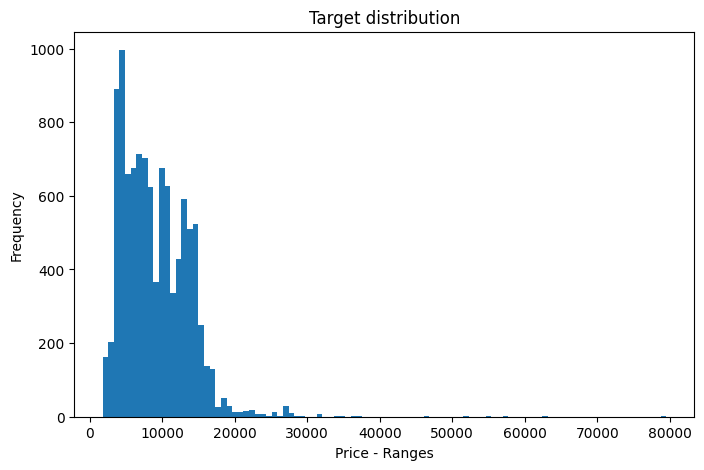

In [34]:

y = Y.values if hasattr(Y, "values") else np.asarray(Y)


print("Min:", y.min())
print("Max:", y.max())
print("Mean:", y.mean())
print("Std:", y.std())


plt.figure(figsize=(8,5))
plt.hist(y, bins=100)
plt.xlabel("Price - Ranges")
plt.ylabel("Frequency")
plt.title("Target distribution")
plt.show()

Min: 7.473637108496206
Max: 11.283688385767459
Mean: 8.981628113924094
Std: 0.5146614403395315


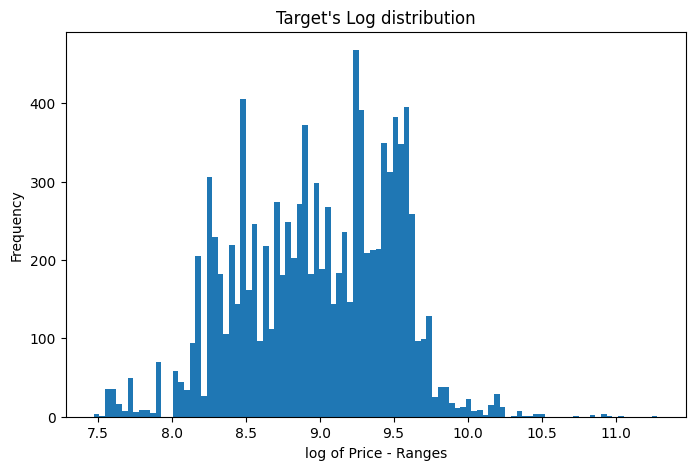

In [35]:
Y = np.array(Y.astype(np.float64))
logY = np.array(np.log1p(1+Y))

y = (logY)


print("Min:", y.min())
print("Max:", y.max())
print("Mean:", y.mean())
print("Std:", y.std())




plt.figure(figsize=(8, 5))
plt.hist(y, bins=100)
plt.xlabel("log of Price - Ranges")
plt.ylabel("Frequency")
plt.title("Target's Log distribution")
plt.show()

### Correlations in Features
> I don't see a lot of redundant/correlated columns

Column 0 correlation shape: (12, 12)


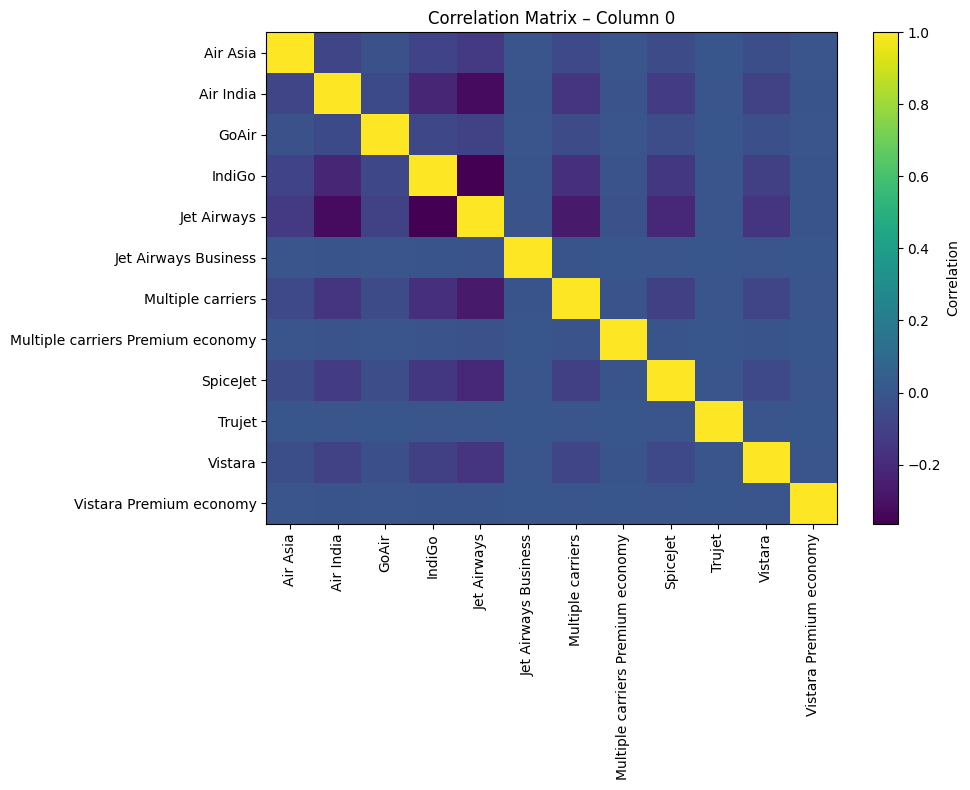

Column 1 correlation shape: (2, 2)


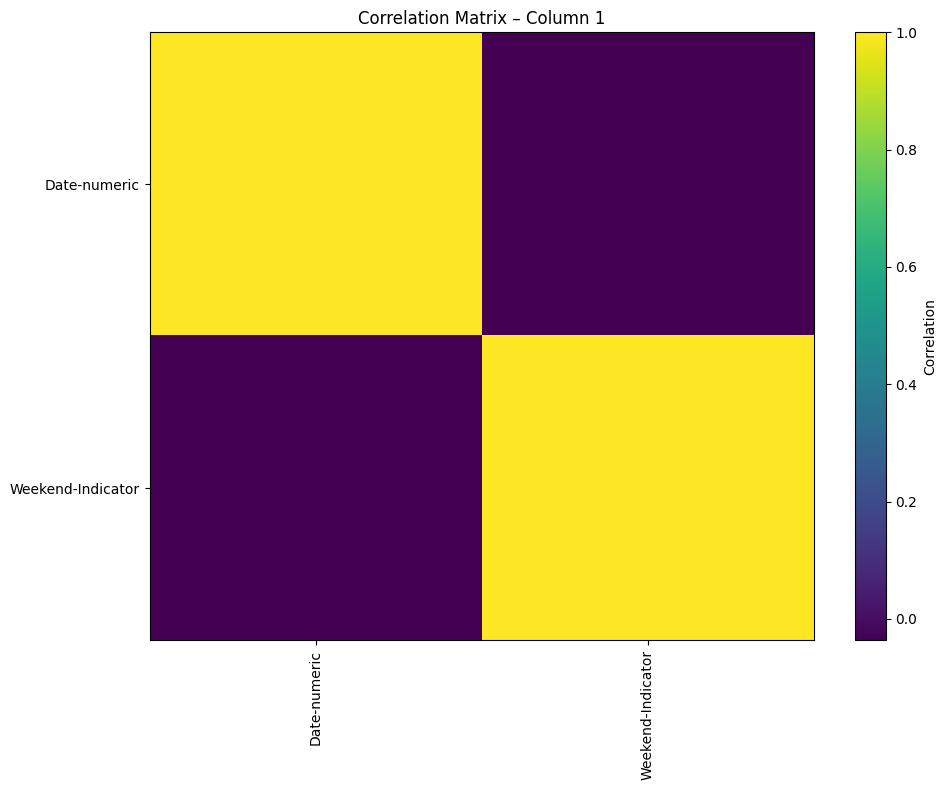

Column 2 correlation shape: (5, 5)


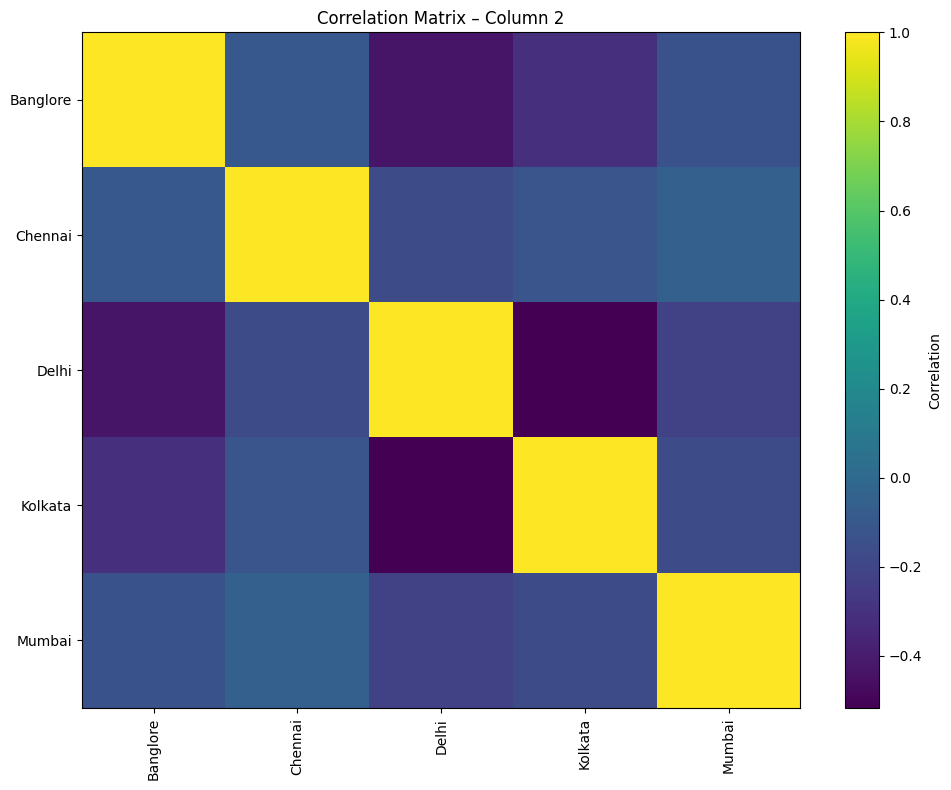

Column 4 correlation shape: (42, 42)


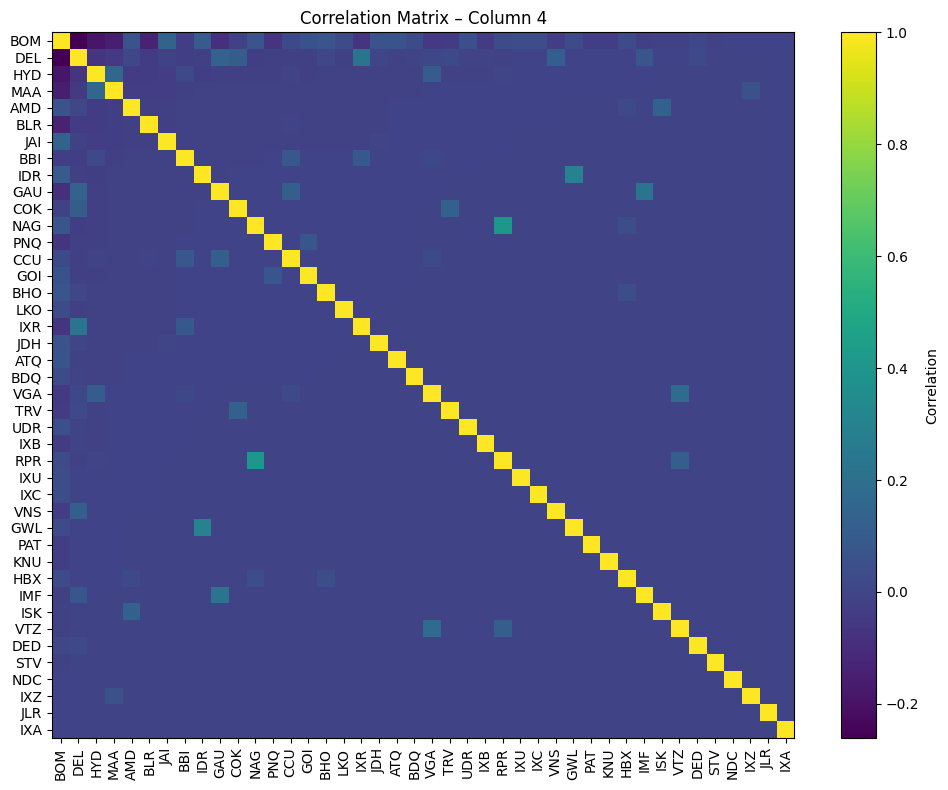

Column 9 correlation shape: (8, 8)


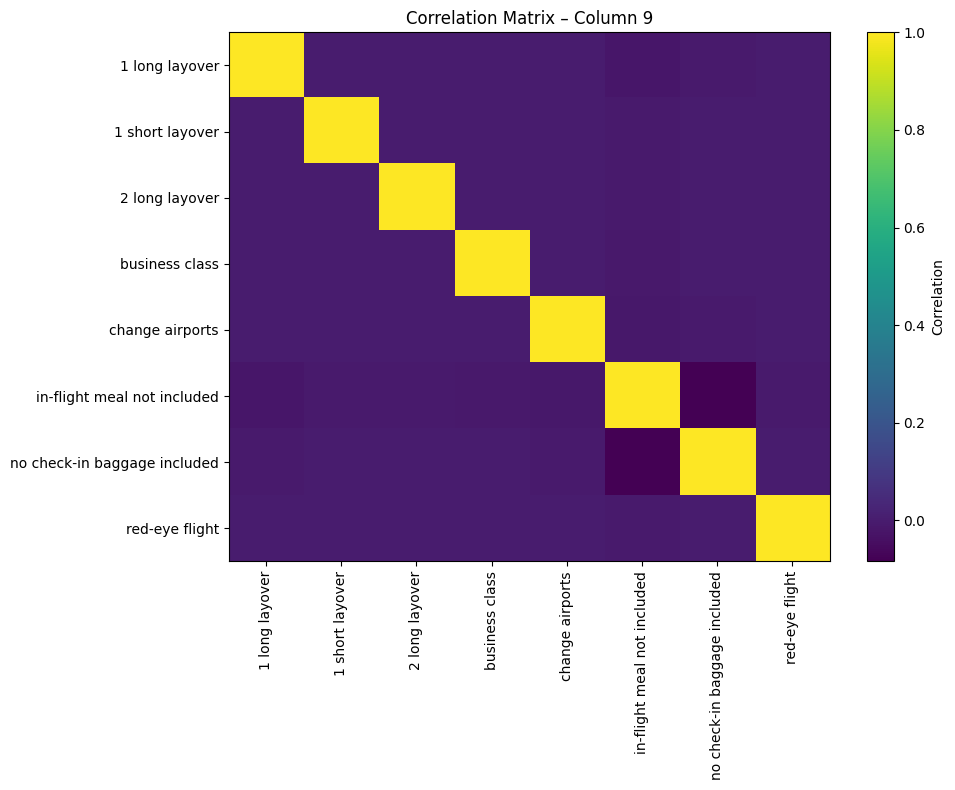

In [36]:
def plot_correlations(data, dataTitles, showAxes = True, autoTitle = False):
    for i in range(len(data)):

        X = np.asarray(data[i])

        # Skip empty array or 1D features
        if X.size == 0 or X.ndim == 1:
            continue

        
        corr = np.corrcoef(X, rowvar=False)                  # correlation
        print(f"Column {i} correlation shape:", corr.shape)

        feature_names = dataTitles[i]

        # # Safety check
        # if corr.shape[0] != len(feature_names):
        #     print(f"Name mismatch in column {i} !!!")
        #     print(feature_names, corr)
        #     continue

        corr_df = pd.DataFrame(
            corr,
            index=feature_names,
            columns=feature_names
        )


        plt.figure(figsize=(10, 8))
        plt.imshow(corr, aspect="auto")
        plt.colorbar(label="Correlation")
        if not autoTitle:
            plt.title(f"Correlation Matrix – Column {i}")
        else:
            plt.title(autoTitle)
        
        if showAxes:
            plt.xticks(range(len(feature_names)), feature_names, rotation=90)
            plt.yticks(range(len(feature_names)), feature_names)
        plt.tight_layout()
        plt.show()

    if len(data) == 1:
        return corr


plot_correlations(colEditList, colEditListNames)


> I will be dropping correlated rows in a few code blocks lines, comparing all features of X

### Comparing Features to Target Variable
What does the Feature look like with respect to Target Variable?

['Air Asia' 'Air India' 'GoAir' 'IndiGo' 'Jet Airways'
 'Jet Airways Business' 'Multiple carriers'
 'Multiple carriers Premium economy' 'SpiceJet' 'Trujet' 'Vistara'
 'Vistara Premium economy']


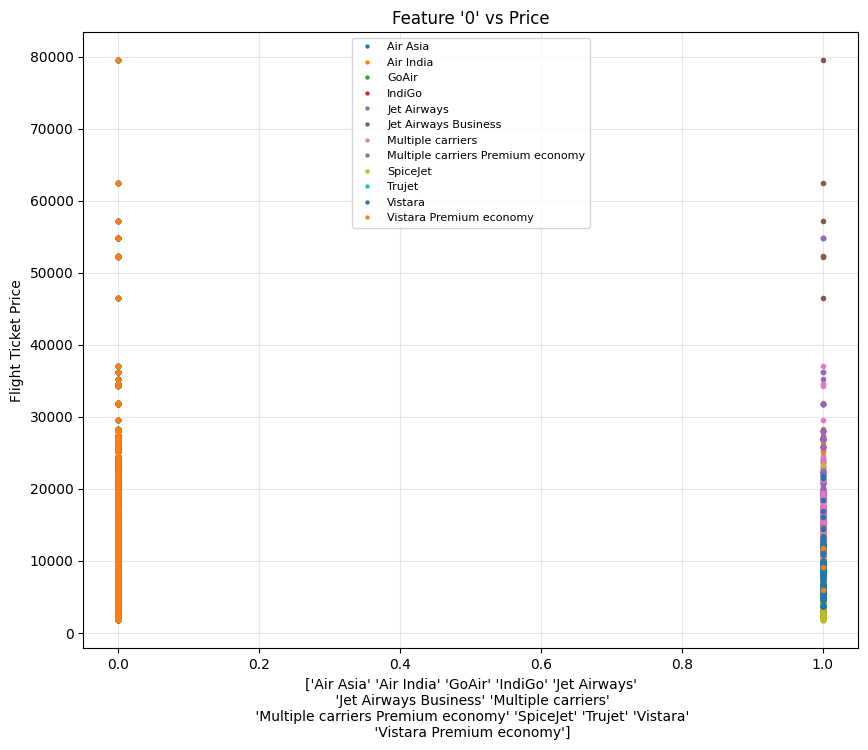

['Date-numeric' 'Weekend-Indicator']


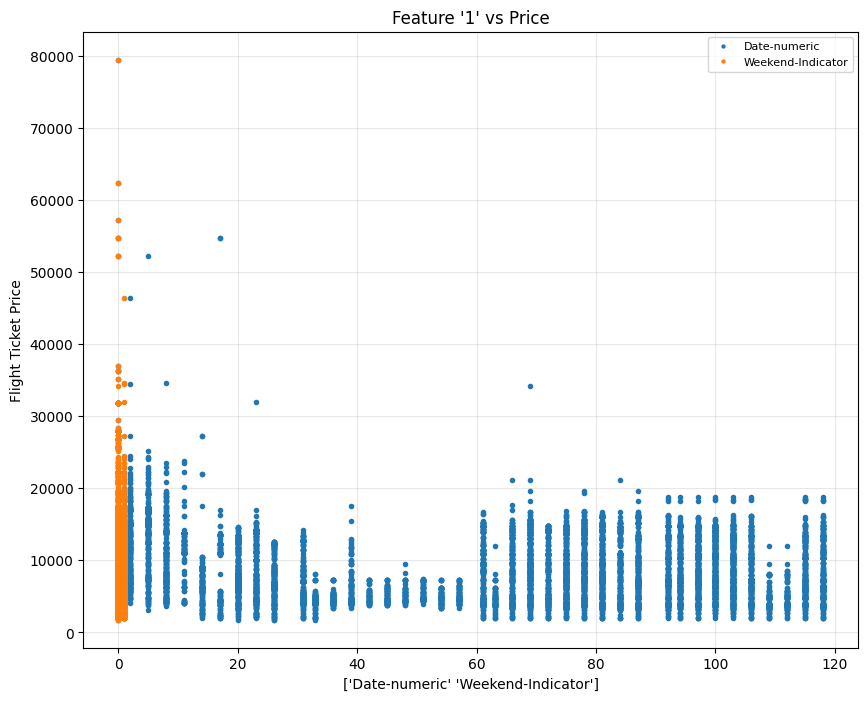

['Banglore' 'Chennai' 'Delhi' 'Kolkata' 'Mumbai']


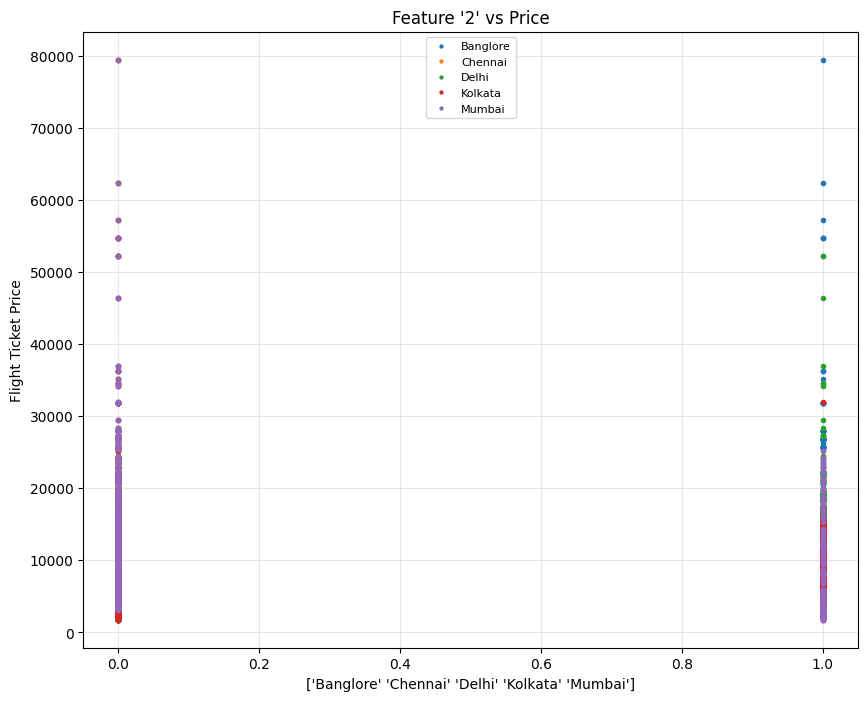

['BOM' 'DEL' 'HYD' 'MAA' 'AMD' 'BLR' 'JAI' 'BBI' 'IDR' 'GAU' 'COK' 'NAG'
 'PNQ' 'CCU' 'GOI' 'BHO' 'LKO' 'IXR' 'JDH' 'ATQ' 'BDQ' 'VGA' 'TRV' 'UDR'
 'IXB' 'RPR' 'IXU' 'IXC' 'VNS' 'GWL' 'PAT' 'KNU' 'HBX' 'IMF' 'ISK' 'VTZ'
 'DED' 'STV' 'NDC' 'IXZ' 'JLR' 'IXA']


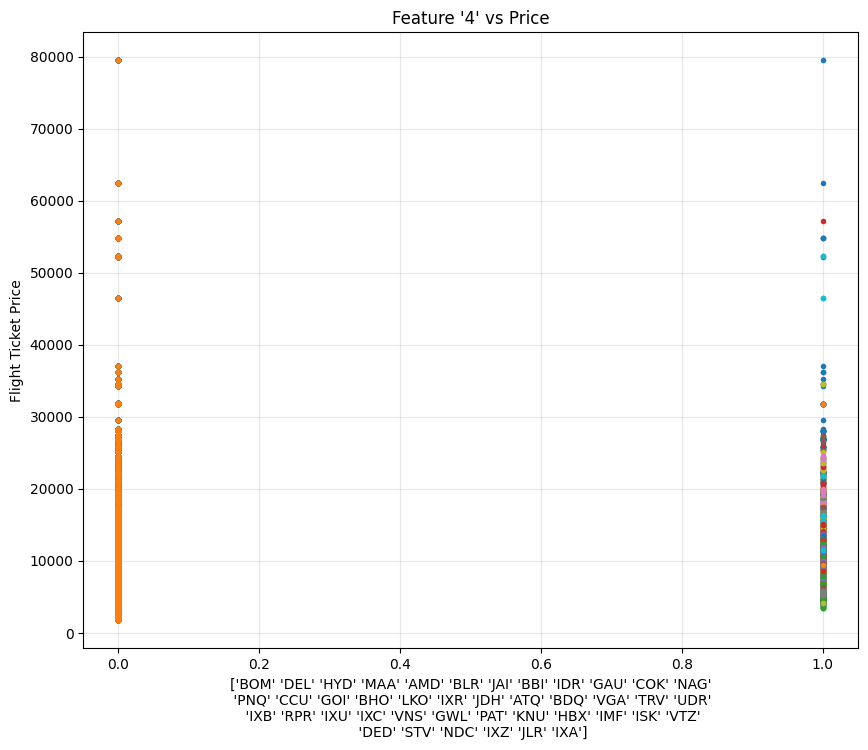

['Departure time numeric']


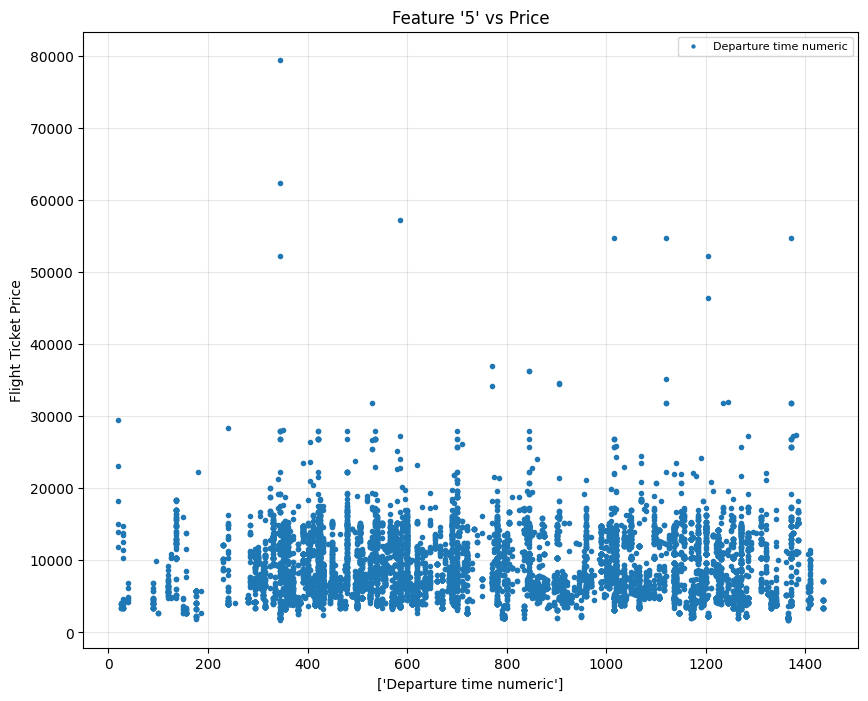

['Arrival time numeric']


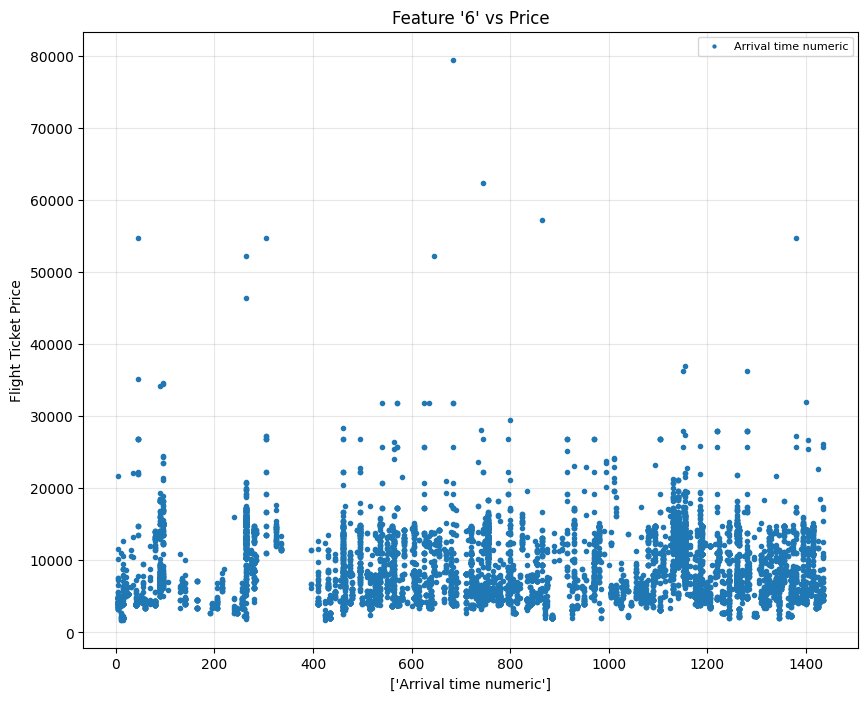

['Duration numeric']


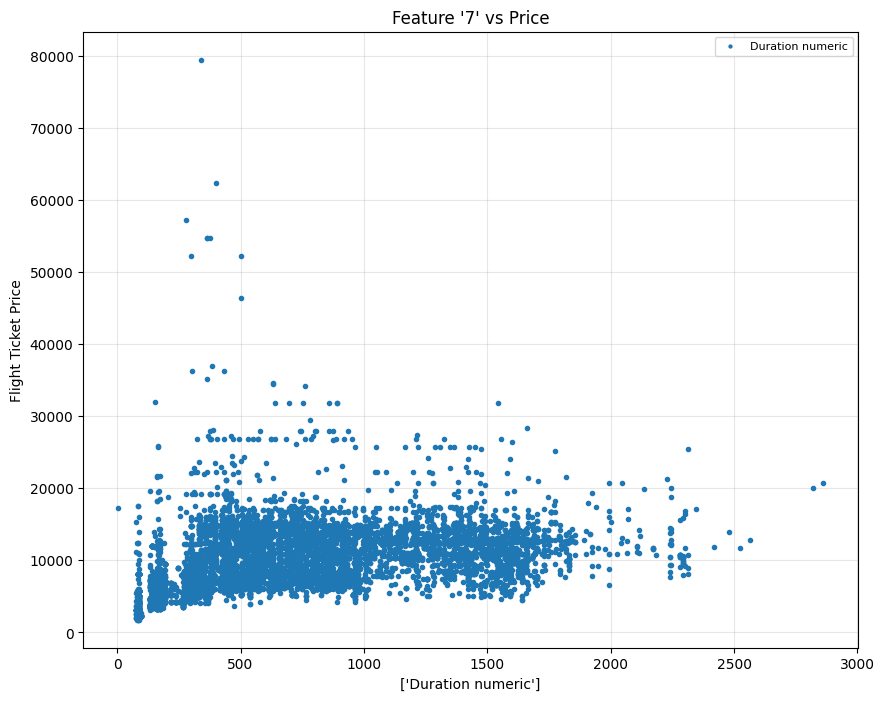

['Stops count']


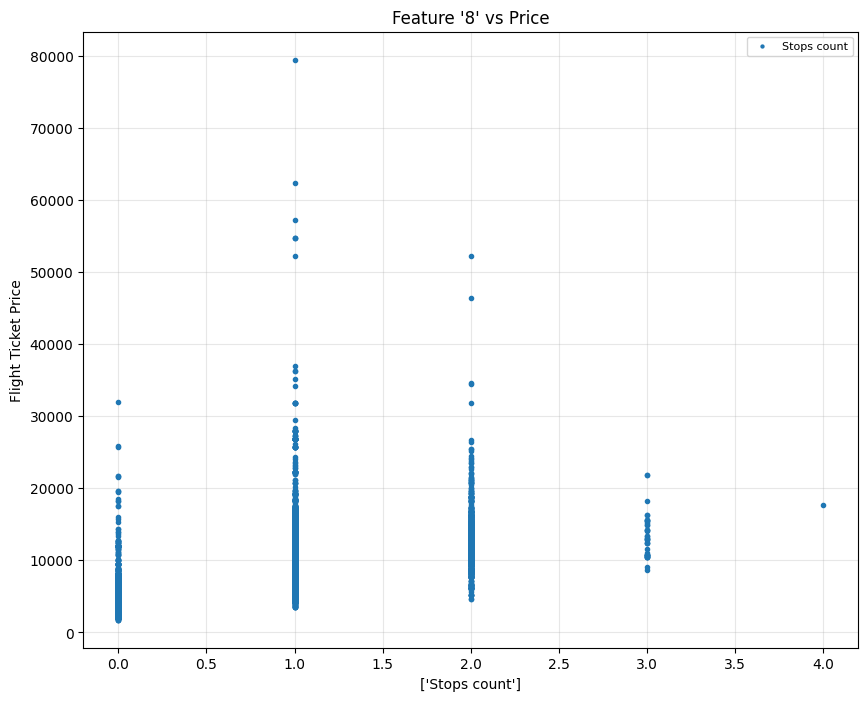

['1 long layover' '1 short layover' '2 long layover' 'business class'
 'change airports' 'in-flight meal not included'
 'no check-in baggage included' 'red-eye flight']


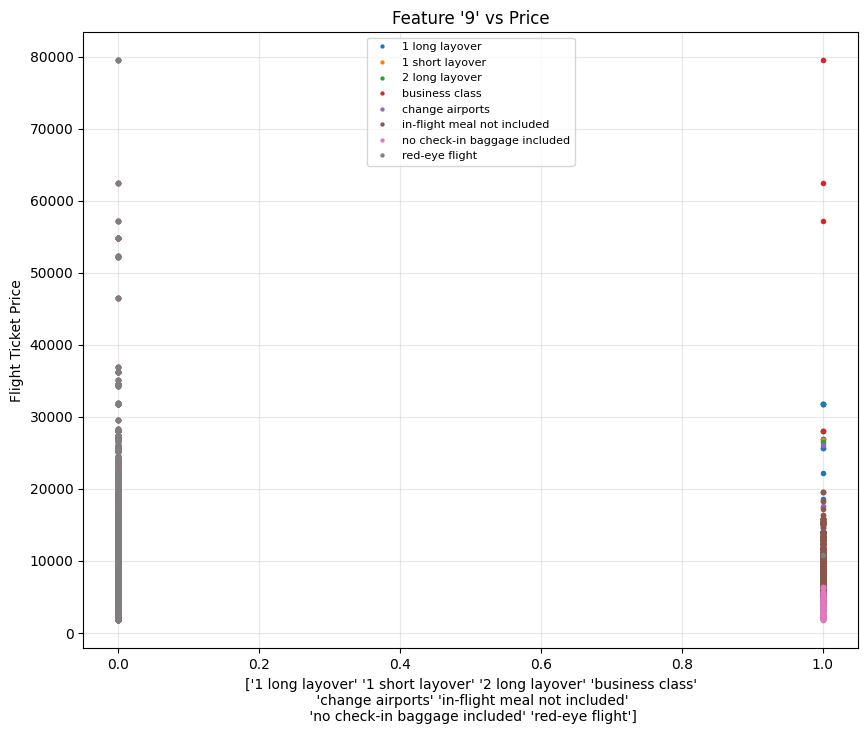

In [37]:
for tempCol in range(len(colEditList)):

    # skip empty columns
    if colEditList[tempCol] is None or len(colEditList[tempCol]) == 0:
        continue

    plt.figure(figsize=(10, 8))

    plt.plot(
        colEditList[tempCol],
        Y,
        '.',
        label=colEditListNames[tempCol]
    )

    plt.xlabel(colEditListNames[tempCol])
    plt.ylabel('Flight Ticket Price')
    plt.title(f"""Feature '{tempCol}' vs Price""")

    if len(colEditListNames[tempCol]) < 15:
        plt.legend(
            fontsize=8,
            markerscale=0.7,
            # frameon=False
        )
    plt.grid(True, alpha=0.3)

    print(colEditListNames[tempCol])
    plt.show()


### Grouping Features $X$, and Target $Y$

In [38]:
X_cols = []
for tempCol in range(len(colEditList)):

    col = colEditList[tempCol]
    

    # skip empty columns (because I store my map that way)
    if col is None or len(col) == 0:
        # print(1)
        continue
    # print(np.shape(col))

    X_cols.append(col)

X_combined = np.column_stack(X_cols)


print(f"Features shape: {' '*5}{X_combined.shape[1]}")
print(f"Sanity check, shape: {np.sum(columnsCount)}")


Features shape:      73
Sanity check, shape: 73.0


In [39]:
# Ordered titles of Columns used in the models

X_columnNames = []

for k in sorted(colEditListNames.keys()):
    names = colEditListNames[k]
    if names is None or len(names) == 0:
        continue
    X_columnNames.extend(names.tolist())

X_columnNames = np.array(X_columnNames)

X_columnNames


array(['Air Asia', 'Air India', 'GoAir', 'IndiGo', 'Jet Airways',
       'Jet Airways Business', 'Multiple carriers',
       'Multiple carriers Premium economy', 'SpiceJet', 'Trujet',
       'Vistara', 'Vistara Premium economy', 'Date-numeric',
       'Weekend-Indicator', 'Banglore', 'Chennai', 'Delhi', 'Kolkata',
       'Mumbai', 'BOM', 'DEL', 'HYD', 'MAA', 'AMD', 'BLR', 'JAI', 'BBI',
       'IDR', 'GAU', 'COK', 'NAG', 'PNQ', 'CCU', 'GOI', 'BHO', 'LKO',
       'IXR', 'JDH', 'ATQ', 'BDQ', 'VGA', 'TRV', 'UDR', 'IXB', 'RPR',
       'IXU', 'IXC', 'VNS', 'GWL', 'PAT', 'KNU', 'HBX', 'IMF', 'ISK',
       'VTZ', 'DED', 'STV', 'NDC', 'IXZ', 'JLR', 'IXA',
       'Departure time numeric', 'Arrival time numeric',
       'Duration numeric', 'Stops count', '1 long layover',
       '1 short layover', '2 long layover', 'business class',
       'change airports', 'in-flight meal not included',
       'no check-in baggage included', 'red-eye flight'], dtype='<U33')

#### Features Seems to have very few correlated rows

Column 0 correlation shape: (73, 73)


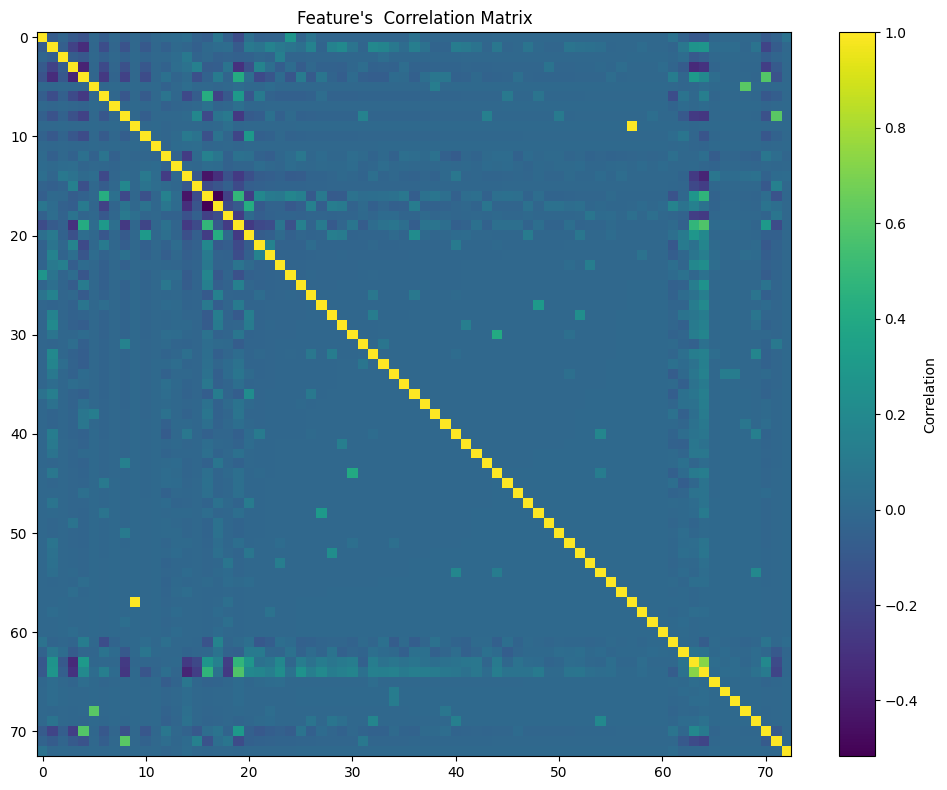

In [40]:
corr = plot_correlations([X_combined], [X_columnNames], showAxes=False, autoTitle="Feature's  Correlation Matrix")

#### Dropping columns that are redundant (>75% correlated)

In [41]:
def drop_correlated_columns_with_trace(
    X,
    corr,
    threshold=0.7,
    drop="j",                # "j" or "i"
    X_columnNames=None,
    verbose=True
):
    """

    Drops one column from each correlated pair |corr[i,j]| > threshold (i>j).
    Returns:
      - X_new
      - names_new (or None)
      - discard_matrix: rows = [dropped_idx, kept_idx, corr_value, dropped_rank, kept_rank]
      - kept_idx (original indices kept, in order)
      - dropped_idx (original indices dropped, sorted)

      i or j changes which of the correlated pair gets dropped !
    """
    n = corr.shape[0]
    pairs = []

    # collect pairs (upper triangle)
    for i in range(1, n):
        for j in range(i):
            r = corr[i, j]
            if abs(r) > threshold:
                pairs.append((i, j, r))

    # drop set
    to_drop = set()
    for i, j, r in pairs:
        to_drop.add(j if drop == "j" else i)

    dropped_idx = sorted(to_drop)
    kept_idx = [k for k in range(n) if k not in to_drop]

    # For each dropped col, store the strongest correlated kept partner (if any)
    discard_rows = []
    for d in dropped_idx:
        best_k = -1
        best_r = 0.0
        for k in kept_idx:
            r = corr[max(d, k), min(d, k)]
            if abs(r) > abs(best_r):
                # print(abs(best_r) ,abs(r))
                best_r = r
                best_k = k

        discard_rows.append([d, best_k, best_r])

    discard_matrix = np.array(discard_rows, dtype=object)

    # reduced X 
    X_new = X[:, kept_idx]
    names_new = None if X_columnNames is None else np.array(X_columnNames)[kept_idx]

    if verbose:
        print(f"Threshold: {threshold} | drop='{drop}'")
        print(f"Kept: {len(kept_idx)} | Dropped: {len(dropped_idx)}")

        if discard_matrix.size > 0:
            # show first 10 rows with names
            show_n = min(10, discard_matrix.shape[0])
            for row in discard_matrix[:show_n]:
                d, k, r = row
                if X_columnNames is None:
                    print(f"dropped={d}, kept_partner={k}, corr={r:+.3f}")
                else:
                    print(f"dropped={d}({X_columnNames[d]}), kept_partner={k}({X_columnNames[k]}), corr={float(r):+.3f}")

    return X_new, names_new, discard_matrix, kept_idx, dropped_idx


In [42]:
X, X_names_new, discarded, kept_idx, dropped_idx = drop_correlated_columns_with_trace(
    X_combined, corr, threshold=0.75, drop="i", X_columnNames=X_columnNames
)

Threshold: 0.75 | drop='i'
Kept: 72 | Dropped: 1
dropped=57(NDC), kept_partner=9(Trujet), corr=+1.000


In [43]:
summary_table = pd.DataFrame(
    {
        "Y": [Y.min(), Y.mean(), Y.max()],
        "logY": [logY.min(), logY.mean(), logY.max()],
        "X": [X.min(), X.mean(), X.max()],
    },
    index=["min", "mean", "max"]
)

X_summary = pd.DataFrame(
    {
        "min":  X.min(axis=0),
        "mean": X.mean(axis=0),
        "max":  X.max(axis=0),
    },
    index=X_names_new
)

display(summary_table)
display(X_summary.head())

,Y,logY,X
min,1759.000000,7.473637,0.000000
mean,9026.790289,8.981628,31.938358
max,79512.000000,11.283688,2860.000000


,min,mean,max
Air Asia,0.0,0.030491,1.0
Air India,0.0,0.161919,1.0
GoAir,0.0,0.018543,1.0
IndiGo,0.0,0.195278,1.0
Jet Airways,0.0,0.353661,1.0


## Normalisation methods
> I plan to decide on 1 normalising method once I train my data using OLS

### Standardisation

> This means that for a data given by $\mathbf{X} = \left(
> \left(\mathbf{x}^{(1)}\right)^{\top},\left(\mathbf{x}^{(2)}\right)^{\top},\ldots,\left(\mathbf{x}^{(s)}\right)^{\top}
> \right) \in \mathbb{R}^{s\times d}$ we define a new, rescaled data as:
> $$
> \hat{\mathbf{x}}^{(i)}_k = \frac{\mathbf{x}^{(i)}_k - \left\langle \mathbf{x}_k \right\rangle }{\left(\sigma_{\mathbf{x}}\right)_k},
> $$
> where $\left\langle \mathbf{x}_k \right\rangle = \frac{1}{s}\sum\limits_{j=1}^s \mathbf{x}^{(j)}_k$, and
> $\left(\sigma_\mathbf{x}\right)_k = \sqrt{
> 	\frac{1}{s}\sum\limits_{j=1}^s \left(\mathbf{x}^{(j)}_k-\left\langle \mathbf{x}_k \right\rangle\right)^2}$
> are the mean and standard deviation of data vector $\mathbf{x}$.  

 *referenced from Coursework 6*

In [44]:
def standardise(data_matrix):
    
    row_of_means = np.mean(data_matrix, axis=0)
    standardised_matrix = data_matrix - row_of_means
    row_of_stds = np.std(data_matrix, axis=0)
    
    return (standardised_matrix / row_of_stds), row_of_means, row_of_stds


def de_standardise(standardised_matrix, row_of_means, row_of_stds):
    matrix = np.copy(standardised_matrix * row_of_stds)
    return matrix + row_of_means

# Sanity check
temp_stdX, temp_row_of_means, temp_row_of_stds  = standardise(X_combined)
tempX = de_standardise(temp_stdX, temp_row_of_means, temp_row_of_stds)

assert_array_almost_equal(X_combined, tempX)

### Robust Scaling

> This means that for a data given by  
> $\mathbf{X} = \left(
> \left(\mathbf{x}^{(1)}\right)^{\top},\left(\mathbf{x}^{(2)}\right)^{\top},\ldots,\left(\mathbf{x}^{(s)}\right)^{\top}
> \right) \in \mathbb{R}^{s\times d}$  
> we define a new, rescaled data as:
> $$
> \hat{\mathbf{x}}^{(i)}_k
> =
> \frac{\mathbf{x}^{(i)}_k - \operatorname{median}\!\left(\mathbf{x}_k\right)}
> {\operatorname{IQR}\!\left(\mathbf{x}_k\right)},
> $$
> where  
> $\operatorname{median}\!\left(\mathbf{x}_k\right)$ is the median of the $k$-th feature, and
> $$
> \operatorname{IQR}\!\left(\mathbf{x}_k\right)
> =
> Q_{0.75}\!\left(\mathbf{x}_k\right)
> -
> Q_{0.25}\!\left(\mathbf{x}_k\right)
> $$
> is the interquartile range of the $k$-th feature, defined as the difference between its 75-th and 25-th percentiles.


In [45]:
def robust_scale(data_matrix, eps=1e-12):
    row_of_medians = np.median(data_matrix, axis=0)
    q75 = np.percentile(data_matrix, 75, axis=0)
    q25 = np.percentile(data_matrix, 25, axis=0)
    row_of_iqrs = q75 - q25

    # safegaurding against zero IQR
    safe_iqrs = np.where(row_of_iqrs == 0, 1.0, row_of_iqrs)

    robust_scaled_matrix = (data_matrix - row_of_medians) / safe_iqrs

    return robust_scaled_matrix, row_of_medians, safe_iqrs


def de_robust_scale(robust_scaled_matrix, row_of_medians, row_of_iqrs):
    matrix = np.copy(robust_scaled_matrix * row_of_iqrs)
    return matrix + row_of_medians

# Sanity check
temp_rX, temp_medians, temp_iqrs = robust_scale(X_combined)
tempX = de_robust_scale(temp_rX, temp_medians, temp_iqrs)

assert_array_almost_equal(X_combined, tempX)


### Log Transformation

> This means that for a data given by  
> $\mathbf{X} = \left(
> \left(\mathbf{x}^{(1)}\right)^{\top},\left(\mathbf{x}^{(2)}\right)^{\top},\ldots,\left(\mathbf{x}^{(s)}\right)^{\top}
> \right) \in \mathbb{R}^{s\times d}$  
> we define a new, transformed data as:
> $$
> \hat{\mathbf{x}}^{(i)}_k
> =
> \log\!\left(\mathbf{x}^{(i)}_k + \varepsilon\right),
> $$
> where $\varepsilon > 0$ is a small constant introduced to ensure numerical stability and to allow the transformation of zero-valued data.


In [46]:
def log_transform(data_matrix, eps=1e-8):
    """
    Applies log(x + eps)
    """
    return np.log(data_matrix + eps), eps

def de_log_transform(log_matrix, eps=1e-8):
    return np.exp(log_matrix) - eps

# Sanity check
temp_logX, eps = log_transform(X_combined)
tempX = de_log_transform(temp_logX, eps)

assert_array_almost_equal(X_combined, tempX)


### Normalisation (Min–Max Scaling to [0, 1])

> This means that for a data given by  
> $\mathbf{X} = \left(
> \left(\mathbf{x}^{(1)}\right)^{\top},\left(\mathbf{x}^{(2)}\right)^{\top},\ldots,\left(\mathbf{x}^{(s)}\right)^{\top}
> \right) \in \mathbb{R}^{s\times d}$  
> we define a new, rescaled data as:
> $$
> \hat{\mathbf{x}}^{(i)}_k
> =
> \frac{\mathbf{x}^{(i)}_k - \min\!\left(\mathbf{x}_k\right)}
> {\max\!\left(\mathbf{x}_k\right) - \min\!\left(\mathbf{x}_k\right)},
> $$
> where $\min\!\left(\mathbf{x}_k\right)$ and $\max\!\left(\mathbf{x}_k\right)$ denote the minimum and maximum values
> of the $k$-th feature across all samples.
>
> This transformation maps each feature independently into the interval $[0,1]$ while preserving the relative ordering
> of the data points.


In [47]:
def minmax_normalise(data_matrix):
    row_of_mins = np.min(data_matrix, axis=0)
    row_of_maxs = np.max(data_matrix, axis=0)

    # protect against constant columns
    ranges = row_of_maxs - row_of_mins
    safe_ranges = np.where(ranges == 0, 1.0, ranges)

    normalised_matrix = (data_matrix - row_of_mins) / safe_ranges

    return normalised_matrix, row_of_mins, safe_ranges

def de_minmax_normalise(normalised_matrix, row_of_mins, safe_ranges):
    matrix = normalised_matrix * safe_ranges
    return matrix + row_of_mins


temp_mmX, temp_mins, temp_ranges = minmax_normalise(X_combined)
tempX = de_minmax_normalise(temp_mmX, temp_mins, temp_ranges)

assert_array_almost_equal(X_combined, tempX)


# Models 

## Index of models
- Simple, Ordinary Least Squares
- Polynomial Regression
- Kernelised Regression
- Ridge Regression
- Lasso Regression with l1 regularisation
- Regression with a Simple Neural Network

### Simple Linear Regression

> Linear regression models the relationship between an input vector $\mathbf{x} \in \mathbb{R}^d$ and a scalar output $y \in \mathbb{R}$ using a linear function:
> $$
> \hat{y}(\mathbf{x}) = \mathbf{w}^\top \mathbf{x} + b,
> $$
> where $\mathbf{w} \in \mathbb{R}^d$ is the weight vector and $b \in \mathbb{R}$ is the bias term.  
> The model parameters are typically estimated by minimising the mean squared error over the training data:
> $$
> \min_{\mathbf{w},b} \frac{1}{s} \sum_{i=1}^{s} \left(y^{(i)} - \hat{y}(\mathbf{x}^{(i)})\right)^2.
> $$

In [48]:
def simple_linear_regression(X, Y, ifPlot = True):
    """
    Linear regression via least squares.

    Parameters
    ----------
    X : array-like, shape (n_samples, n_features)
    Y : array-like, shape (n_samples,) or (n_samples, 1)
    add_intercept : bool
        If True, includes a bias term.
    ifPlot : Bool indicator if Visualisation is needed

    Returns
    -------
    w : ndarray
        Weights (including intercept first if add_intercept=True)
    R2 : float
        Coefficient of determination
    """
    Y = np.asarray(Y).reshape(-1)
    X = np.c_[np.ones((X.shape[0], 1)), X]               # for bias


    # simple Linear Weights

    # w = np.linalg.solve(X.T @ X, X.T @ Y)
    w = np.linalg.pinv(X.T @ X) @ X.T @ Y             # more stable


    yPred = X @ w                                          # predicted Y values
    predictionError = Y - yPred                            # Error calculated with respect to actual values
    SqSumErr = np.sum(predictionError**2)
    SqSumTarget = np.sum((Y - np.mean(Y))**2)              # Unscaled Target Variance
    
    # Goodness of Fit
    R2 = 1 - SqSumErr / SqSumTarget  
    if ifPlot:
        plt.title("Prediction to Actual Plot")
        plt.scatter(Y, yPred)
        mn = min(Y.min(), yPred.min())
        mx = max(Y.max(), yPred.max())
        plt.plot([mn, mx], [mn, mx])                    # reference line
        plt.xlabel("Actual Y")
        plt.ylabel("Predicted Y")
        plt.show()


        plt.title("heteroscedacity plot")
        plt.xlabel("Residuals")
        plt.ylabel("Predicted Y")
        
        plt.plot(predictionError, yPred, '.')
        plt.show()

    return w, R2

def linear_regression_prediction(X, w, Y = False, ifPlot = True):
    """
    Using the weights calculated throughLinear regression via least squares to predict Target

    Parameters
    ----------
    X : Test Data Matrix
    w : Model Parameter (weights of the Features)
    Y : Test actual Target values

    Returns
    -------
    yPred : predicted labels for given Data using given weights
    R2 : Goodness of fit
    """

    # for safety
    Y = np.asarray(Y).reshape(-1)

    # add bias term 
    X = np.c_[np.ones((X.shape[0], 1)), X]


    yPred = X @ w
    predictionError = Y - yPred
    
    # SqSumErr = np.sum(predictionError**2) 
    # SqSumTarget = np.sum((Y - np.mean(Y))**2)

    # R2 = 1 - SqSumErr / SqSumTarget                    # Score

    if ifPlot and Y:
        plt.scatter(Y, yPred)
        mn = min(Y.min(), yPred.min())
        mx = max(Y.max(), yPred.max())
        plt.plot([mn, mx], [mn, mx])
        plt.xlabel("Actual Y")
        plt.ylabel("Predicted Y")
        plt.show()

    # mse = np.mean((Y - yPred)**2)
    # return mse, R2
    return yPred



### Polynomial Regression

> Polynomial regression extends linear regression by applying a **non-linear feature mapping** to the input data, while remaining **linear in the model parameters**.  
> Given an input vector $\mathbf{x} \in \mathbb{R}^d$, we construct an augmented feature vector $\boldsymbol{\phi}(\mathbf{x})$ by including powers of the original features:
> $$
> \boldsymbol{\phi}(\mathbf{x}) =
> \begin{bmatrix}
> 1 \\
> \mathbf{x} \\
> \mathbf{x}^{ 2} \\
> \vdots \\
> \mathbf{x}^{ p}
> \end{bmatrix},
> $$
> where $\mathbf{x}^{ k}$ denotes the element-wise $k$-th power of $\mathbf{x}$ and $p$ is the polynomial degree.
>
> The regression model then takes the form
> $$
> \hat{y}(\mathbf{x}) = \mathbf{w}^\top \boldsymbol{\phi}(\mathbf{x}),
> $$
> where $\mathbf{w}$ contains the weights corresponding to each polynomial feature, including the bias term.
>
> After feature augmentation, the model parameters are estimated using **ordinary least squares (OLS)**, exactly as in simple linear regression.

#### My Feature Matrix Structure

> For an original dataset with $d = 72$ features and polynomial degree $p$, the augmented design matrix is organised as follows:
>
> - **Column 0**: Bias (constant 1)  
> - **Columns 1 – 72**: Degree-1 features ($\mathbf{x}$)  
> - **Columns 73 – 144**: Degree-2 features ($\mathbf{x}^{ 2}$)  
> - $\;\;\vdots$  
> - **Subsequent blocks**: Higher-degree polynomial features up to degree $p$
>
> Each block of 72 columns corresponds to the original features raised to a fixed power, allowing the model to capture non-linear relationships while preserving a linear optimisation problem.



 > $!$ $!$ $!$ $!$ $!$ $!$ \
>  Columns with Binary entries (Mostly One-Hot Entries) are unchanged when Exponentiated, this causes Singular matrices \
>  Thus those rows are ignored

In [49]:
def polynomial_augment(X, degree):
    X = np.asarray(X)
    X_poly = X.copy()
    
    if degree == 0:
        # print("zzzz")
        return np.ones((X.shape[0], 1))

    for d in range(2, degree + 1):

        # only add powers for non-binary columns, as binary variables scaled still gives the same thing, making my matrix singular 
        newCols = []
        for j in range(X.shape[1]):
            col = X[:, j]

            # check if column is binary {0,1}
            uniq = np.unique(col)
            isBinary = (uniq.size <= 2) and np.all((uniq == 0) | (uniq == 1))

            if not isBinary:
                newCols.append(col ** d)

        if len(newCols) > 0:
            X_poly = np.c_[X_poly, np.column_stack(newCols)]

    return X_poly


### Kernel Regression


#### Radial Basis Function (RBF) Regression

> The RBF regression model predicts the output using a kernel expansion:
> $$
> \hat{y}(\mathbf{x}) = \sum_{i=1}^{s} \alpha_i 
> \exp\!\left(-\gamma \, \lVert \mathbf{x} - \mathbf{x}^{(i)} \rVert^2 \right),
> $$
> where $\gamma > 0$ controls the width of the radial basis functions and
> $\alpha_i$ are the learned coefficients.


In [50]:
def RBF_kernel_regression(X, Y, gamma = 0.1, lam = 1e-2, ifPlot = True):
    """
    Radial Basis Function - Regression

    Parameters
    ----------
    X : array-like, shape (n_samples, n_features)
    Y : array-like, shape (n_samples,) or (n_samples, 1)
    add_intercept : bool
        If True, includes a bias term.
    ifPlot : Bool indicator if Visualisation is needed
    gamma  : Hyper-parameter to width multiplier
    lam    : Hyper-parameter to regularise

    Returns
    -------
    a : ndarray
        Weights (including intercept first if add_intercept=True)
    R2 : float
        Coefficient of determination
    """

    Y = np.asarray(Y).reshape(-1)

    X2 = np.sum(X*X, axis=1, keepdims=True)
    D2 = X2 + X2.T - 2*(X @ X.T)
    K = np.exp(-gamma * D2)

    a = np.linalg.solve(K + lam*np.eye(K.shape[0]), Y)  # faster and safer than linalg.inv 

    if ifPlot:
        plt.scatter(Y, K @ a, alpha=0.3)
        mn, mx = Y.min(), Y.max()
        plt.plot([mn, mx], [mn, mx])
        plt.show()

    yPred = K @ a

    SSE = np.sum((Y - yPred)**2)
    SST = np.sum((Y - np.mean(Y))**2)

    R2 = 1 - SSE / SST
    # print("R2 =", R2)

    return a, R2

def RBF_kernel_regression_predictor(a, X, X_train, Y, gamma=0.1, ifPlot=True):
    X2 = np.sum(X*X, axis=1, keepdims=True)
    Xtr2 = np.sum(X_train*X_train, axis=1, keepdims=True).T
    D2 = X2 + Xtr2 - 2*(X @ X_train.T)
    K = np.exp(-gamma * D2)

    a = np.asarray(a).reshape(-1)
    assert K.shape[1] == a.shape[0], f"Shape mismatch: K{K.shape} @ a{a.shape}. swapped X and X_train?"

    yPred = K @ a

    if ifPlot and (Y is not None):
        Y = np.asarray(Y).reshape(-1)
        plt.scatter(Y, yPred)
        mn = min(Y.min(), yPred.min())
        mx = max(Y.max(), yPred.max())
        plt.plot([mn, mx], [mn, mx])
        plt.xlabel("Actual Y")
        plt.ylabel("Predicted Y")
        plt.show()

    return yPred


### Ridge Regression

> Ridge regression extends ordinary least squares by adding an $\ell_2$ penalty on the model parameters to control overfitting and multicollinearity.  
> The model is obtained by solving
> $$
> \min_{\mathbf{w},\,b} \;
> \frac{1}{s} \sum_{i=1}^{s}
> \left(y^{(i)} - \mathbf{w}^\top \mathbf{x}^{(i)} - b \right)^2
> + \lambda \, \lVert \mathbf{w} \rVert_2^2,
> $$
> where $\lambda \ge 0$ is the regularisation parameter.
>
> This leads to the closed-form solution
> $$
> \hat{\mathbf{w}} =
> \left(X^\top X + \lambda I\right)^{-1} X^\top \mathbf{y},
> $$
> which stabilises the estimation when features are highly correlated.





In [51]:
def ridge_regression(X, Y, lam, ifPlot = True):
    """
    Ridge regression via least squares.

    Parameters
    ----------
    X : array-like, shape (n_samples, n_features)
    Y : array-like, shape (n_samples,) or (n_samples, 1)
    add_intercept : bool
        If True, includes a bias term.
    ifPlot : Bool indicator if Visualisation is needed

    Returns
    -------
    w : ndarray
        Weights (including intercept first if add_intercept=True)
    R2 : float
        Coefficient of determination
    """
    Y = np.asarray(Y).reshape(-1)
    X = np.c_[np.ones((X.shape[0], 1)), X] # for bias weights



    XtX = X.T @ X

    I = np.eye(XtX.shape[0])
    I[0, 0] = 0                                         # not penalising intercept
    w = np.linalg.solve(XtX + lam * I, X.T @ Y)


    yPred = X @ w
    predictionError = Y - yPred
    SqSumErr = np.sum(predictionError**2)
    SqSumTarget = np.sum((Y - np.mean(Y))**2)
    
    # Goodness of Fit
    R2 = 1 - SqSumErr / SqSumTarget  
    if ifPlot:
        plt.scatter(Y, yPred)
        mn = min(Y.min(), yPred.min())
        mx = max(Y.max(), yPred.max())
        plt.plot([mn, mx], [mn, mx])   # reference line
        plt.xlabel("Actual Y")
        plt.ylabel("Predicted Y")
        plt.show()

        plt.plot(predictionError, yPred, '.')
        plt.show()

    return w, R2


### l1 regularisation / Lasso Regression - Using ISTA

> Lasso regression estimates the model parameters by solving
> $$
> \min_{\mathbf{w}}
> \;\frac{1}{2}\|X\mathbf{w} - \mathbf{y}\|_2^2
> + \lambda \|\mathbf{w}\|_1,
> $$
> where $\lambda \ge 0$ controls the strength of the $\ell_1$ regularisation.
>
> Due to the non-differentiability of the $\ell_1$ norm, the problem is commonly solved using
> **forward–backward splitting ISTA(Iterative Soft-Thresholding Algorithm)**, consisting of a gradient step on the squared loss
> followed by a soft-thresholding operation that promotes sparsity in the solution.


In [52]:
def soft_tau(z, tau):
    """
    Soft-thresholding operator: 
        soft_tau(z) = sign(z) * max(|z| - tau, 0)
    """
    return np.sign(z) * np.maximum(np.abs(z) - tau, 0.0)


def lasso(X, Y, lam=1e-2, tau=1e-5, n_iters=2000, w0=None):
    """
    Lasso via forward-forward splitting / ISTA (as in slides):

        w^{k+1/2} = w^k - tau * X^T (X w^k - y)
        w^{k+1}   = soft_{tau*lam}( w^{k+1/2} )

    Caution only tau we need for Convergence is:
    - tau/ alpha < || XtX ||^-1

    - So I don't have to hyperparameter tune considering that the hyperparamter ranges are in the safe tau ranges
    """
    X = np.asarray(X, dtype=float)
    Y = np.asarray(Y, dtype=float).reshape(-1)

    # add bias
    X = np.c_[np.ones((X.shape[0], 1)), X]

    n_features = X.shape[1]
    w = np.zeros(n_features) if w0 is None else np.asarray(w0, dtype=float).reshape(-1)

    for _ in range(n_iters):
        # forward-forward splits
        
        r = X @ w - Y
        w_half = w - tau * (X.T @ r)

        # soft-threshold
        w_new = soft_tau(w_half, tau * lam)
        
        w_new[0] = w_half[0]
        w = w_new

    return w


### Neural Network Regression

> A single hidden–layer feedforward neural network is used to model nonlinear relationships between the input features and the target.  
> The model is defined as
> $$
> \hat y(\mathbf{x}) = \mathbf{W}_2 \, \phi(\mathbf{W}_1 \mathbf{x} + \mathbf{b}_1) + \mathbf{b}_2,
> $$
> where $\phi(\cdot)$ denotes an element-wise activation function (tanh or ReLU).
>
> The network parameters are trained by minimising the mean squared error using
> gradient descent and backpropagation:
> $$
> \min_{\mathbf{W}_1,\mathbf{W}_2,\mathbf{b}_1,\mathbf{b}_2}
> \frac{1}{s}\sum_{i=1}^{s} \left(y^{(i)} - \hat y(\mathbf{x}^{(i)})\right)^2.
> $$
>
> Predictions are obtained via a forward pass through the network using the
> learned parameters.


In [53]:
def Simple_NN(X, Y, hidden=32, lr=1e-3, n_iters=60000, ifPlot=True, seed=0, tanNotReLU = True):
    """
    Neural Network Regression (1 hidden layer):
        X -> Linear -> ReLU -> Linear -> yPred
    """

    rng = np.random.default_rng(seed)
    Y = np.asarray(Y, dtype=float).reshape(-1, 1)

    n, d = X.shape

    # initialise weights
    W1 = rng.normal(0.0, 0.1, size=(d, hidden))
    b1 = np.zeros((1, hidden))
    W2 = rng.normal(0.0, 0.1, size=(hidden, 1))
    b2 = np.zeros((1, 1))

    for _ in range(n_iters):

        # forward pass
        Z1 = X @ W1 + b1                 # linear
        if tanNotReLU:
            A1 = np.tanh(Z1)               # tanh
        else:                                # (or)         # Checking locally gave better resutls with tanh
            A1 = np.maximum(0.0, Z1)         # ReLU

        yPred = A1 @ W2 + b2             # linear

        # loss gradient (MSE)
        dY = (2.0 / n) * (yPred - Y)     # dL/dyPred = d((1/n) Σ (ŷ − y)²)/dy

        # backprop
        dW2 = A1.T @ dY
        db2 = np.sum(dY, axis=0, keepdims=True)

        dA1 = dY @ W2.T

        if tanNotReLU:
            dZ1 = dA1 * (1 - A1**2)               # tanh
        else:                                      # (or)         # Checking locally, gave better resutls with tanh
            dZ1 = dA1 * (Z1 > 0.0)               # ReLU


        dW1 = X.T @ dZ1
        db1 = np.sum(dZ1, axis=0, keepdims=True)

        # gradient descent
        W1 -= lr * dW1
        b1 -= lr * db1
        W2 -= lr * dW2
        b2 -= lr * db2

    #
    print(yPred.shape)

    yPred = yPred.reshape(-1)
    
    #
    print(yPred.shape)

    Yflat = Y.reshape(-1)

    # R2
    SSE = np.sum((Yflat - yPred)**2)
    SST = np.sum((Yflat - np.mean(Yflat))**2)
    R2 = 1 - SSE / SST if SST > 0 else np.nan

    if ifPlot:
        plt.scatter(Yflat, yPred, alpha=0.3)
        mn, mx = Yflat.min(), Yflat.max()
        plt.plot([mn, mx], [mn, mx])
        plt.title("Training Fit of the Model for Neural Netrworks")
        plt.xlabel("Actual Y")
        plt.ylabel("Predicted Y")
        plt.show()

    return (W1, b1, W2, b2), yPred

def NN_regression_predict(X, params, tanNotReLU = True):
    """
    Forward pass (Prediction) for 1-hidden-layer NN regression.

    params = (W1, b1, W2, b2)
    """
    W1, b1, W2, b2 = params

    X = np.asarray(X, dtype=float)

    Z1 = X @ W1 + b1
    if tanNotReLU:
        A1 = np.tanh(Z1)               # tanh
    else:                                 # (or)         # Checking locally, gave better resutls with tanh
        A1 = np.maximum(0.0, Z1)         # ReLU
    yPred = A1 @ W2 + b2       # linear output

    return yPred.reshape(-1)

# Train, Validation & Test Setup

> **Training Data** \
  The data split (determined by k-fold cross-validation) used to train the model.

> **Validation Data** \
  The data split (determined by k-fold cross-validation) used primarily for
  hyperparameter tuning and model selection.

> **Test Data** \
  The final, held-out data split used to evaluate the model’s performance
  after training and validation.


## The Train Split

### Reproducible Train–Test Split

> Although pseudo-randomness is used, the fixed seed ensures that the same split is produced every time the function is executed with the same inputs, making the procedure fully reproducible.


In [54]:
def train_test_split(X, Y):
    # Fixing seed '42' for Reproducibility
    rng = np.random.default_rng(seed=42)

    n_samples = X.shape[0]
    indices = rng.permutation(n_samples)

    # Define split sizes
    train_size = int(0.85 * n_samples)


    train_idx = indices[:train_size]

    test_idx = indices[train_size:]

    X_train, Y_train = X[train_idx], Y[train_idx]
    X_test, Y_test   = X[test_idx], Y[test_idx]

    # train_idx.shape[0]+ test_idx.shape[0]
    return X_train, Y_train, X_test, Y_test

## The Train-Validation Split

### Reproducible K-Fold Cross-Validation

> In K-Fold cross-validation, the training data is partitioned into 'k' disjoint subsets (folds). One fold ('i'th) as the Validation and other k-1 splits combined as train. 
> 
> By fixing the random seed when permuting indices, the fold assignments are deterministic and reproducible. Across all \( k \) iterations, each observation appears exactly once in the validation set, and the union of all validation folds recovers the original training dataset.

In [55]:
def k_fold_indices(X, Y, k, i):

    # again setting seed for reproducibility
    seed=0
    
    n = X.shape[0]
    assert 0 <= i < k

    idx = np.arange(n)

    rng = np.random.default_rng(seed)
    rng.shuffle(idx)

    fold_sizes = np.full(k, n // k, dtype=int)
    fold_sizes[: n % k] += 1

    start = sum(fold_sizes[:i])
    end = start + fold_sizes[i]

    val_idx = idx[start:end]
    train_idx = np.concatenate((idx[:start], idx[end:]))

    return X[train_idx], Y[train_idx], X[val_idx], Y[val_idx]


# Metrics
> Numerical values that represent the relation between prediction and true value

In [56]:
def r2(Y, y_pred):
    Y = Y.reshape(-1)
    y_pred = y_pred.reshape(-1)
    ss_res = np.sum((Y - y_pred) ** 2)
    ss_tot = np.sum((Y - np.mean(Y)) ** 2)
    if ss_tot == 0:
        return 0.0
    return float(1.0 - ss_res / ss_tot)

def mse(Y, y_pred):
    Y = Y.reshape(-1)
    y_pred = y_pred.reshape(-1)
    return float(np.mean((Y - y_pred) ** 2))


# Training the models

### Model optimisation setup, K = 10 folds

In [57]:
X_train1, Y_train, X_test1, Y_test = train_test_split(X, Y)
X_train, logY_train, X_test, logY_test = train_test_split(X, logY)
kFoldResults = {}

X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

# Sanity Check so X splits are same wrt Y and logY
np.array_equal(X_test1, X_test) and np.array_equal(X_train1, X_train)


True

In [58]:
# K-Fold: K
K = 10

## OLS

For OLS, I optimise the models by exploring the following 3D configuration space:

- **Target transformation (2):** Y, log(Y)  
- **Model type (6):** OLS, Ridge, Polynomial, Kernelised, Lasso, Neural Network  
- **Feature preprocessing (4):** Standardisation, Robust scaling, Log transformation, Normalisation [0, 1]  

Total configurations = 2 * 6 * 4 = 48.
> We will see from this (in OLS Visualisations exactly) that Standard Normalisation works well, so we will be using that for hyperparameter tuning next models

In [59]:
# Runs the OLS model for a range of normaliser functions, over the K folds - for Y and logY transformation

        # (Y & logY) * (normaliser) * (K-folds)
        # ( target   ,  normaliser  , K-folds )
OLS_R2_tnk = np.zeros((2, 4, K))
OLS_MSE_tnk = np.zeros((2, 4, K))

for n in range(4):
    if n == 0:
        X_train_norm, X_row_of_means, X_row_of_stds  = standardise(X_train)
    elif n == 1:
        X_train_norm, X_row_of_medians, X_safe_iqrs  = robust_scale(X_train)
    elif n == 2:
        X_train_norm, X_eps  = log_transform(X_train)
    elif n == 3:
        X_train_norm, X_row_of_mins, X_safe_ranges  = minmax_normalise(X_train)
    
    for i in range(K):
        X_train_i, Y_train_i, X_val_i, Y_val_i = k_fold_indices(X_train_norm, Y_train, K, i)
        X_train_i, logY_train_i, X_val_i, logY_val_i = k_fold_indices(X_train_norm, logY_train, K, i)

        w_temp, r_temp = simple_linear_regression(X_train_i, Y_train_i, ifPlot=False)
        yPred_temp = linear_regression_prediction(X_val_i, w_temp, ifPlot=False)

        OLS_MSE_tnk[0, n, i] = mse(Y_val_i, yPred_temp)
        OLS_R2_tnk[0, n, i] = r2(Y_val_i, yPred_temp)

        w_temp, r_temp = simple_linear_regression(X_train_i, logY_train_i, ifPlot=False)
        yPred_temp = linear_regression_prediction(X_val_i, w_temp, ifPlot=False)

        Y_val_temp = de_log_transform(logY_val_i)
        Ypred_val_temp = de_log_transform(yPred_temp)

        OLS_MSE_tnk[1, n, i] = mse(Y_val_temp, Ypred_val_temp)
        OLS_R2_tnk[1, n, i] = r2(Y_val_temp, Ypred_val_temp)



In [60]:
# only OLS plotters

def plot_dist_params(means, stds, metric = "R²", model = "OLS"):
    normalisers = ["Standard", "Robust", "Log-X", "MinMax"]
    x = np.arange(len(normalisers))
    width = 0.35

    mean_Y    = means[0]
    std_Y     = stds[0]

    mean_logY = means[1]
    std_logY  = stds[1]

    plt.figure(figsize=(7,4))

    plt.bar(x - width/2, mean_Y, width, yerr=std_Y, capsize=6, label="Y")
    plt.bar(x + width/2, mean_logY, width, yerr=std_logY, capsize=6, label="logY → Y")

    plt.xticks(x, normalisers)
    plt.ylabel(metric)
    plt.title(f"{model} {metric} performance (10-fold CV)")
    plt.legend()
    plt.show()


def plot_dist(allReports, metric = "R²", model = "OLS"):
    fig, axes = plt.subplots(1, 2, figsize=(10,4), sharey=True)
    normalisers = ["Standard", "Robust", "Log-X", "MinMax"]

    axes[0].boxplot(
        [allReports[0, j, :] for j in range(4)],
        labels=normalisers
    )
    axes[0].set_title("Target Y")
    axes[0].set_ylabel(f"{metric}")

    axes[1].boxplot(
        [allReports[1, j, :] for j in range(4)],
        labels=normalisers
    )
    axes[1].set_title("logY → Y")

    fig.suptitle(f"{model} {metric} distribution across 10-fold CV")
    plt.show()


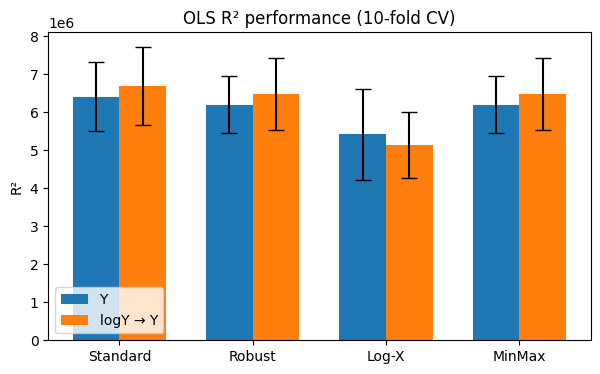

/var/folders/x7/qg3pwzcj4lq7gkhkzz_qd6c80000gn/T/ipykernel_11333/3483397089.py:30: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0].boxplot(
/var/folders/x7/qg3pwzcj4lq7gkhkzz_qd6c80000gn/T/ipykernel_11333/3483397089.py:37: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1].boxplot(


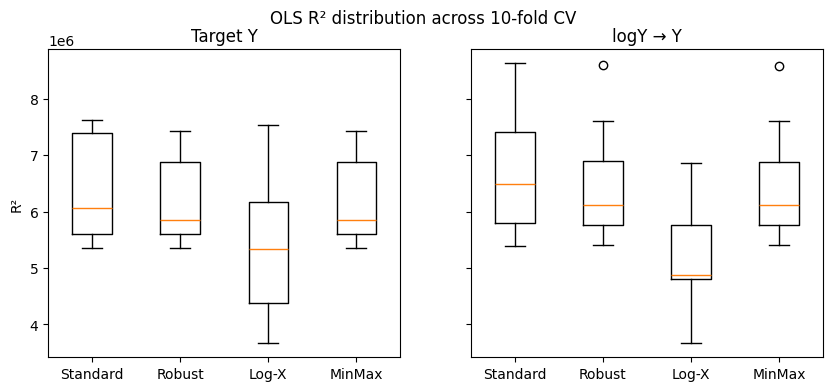

In [61]:
# # OLS plotting
OLS_MSE_mean_tn = OLS_MSE_tnk.mean(axis=2)
OLS_MSE_std_tn  = OLS_MSE_tnk.std(axis=2)

OLS_R2_mean_tn  = OLS_R2_tnk.mean(axis=2)
OLS_R2_std_tn   = OLS_R2_tnk.std(axis=2)

plot_dist_params(OLS_MSE_mean_tn, OLS_MSE_std_tn)

plot_dist(OLS_MSE_tnk)


## Polynomial Regression

> Takes about 40 seconds on my PC


In [62]:
# Runs the Regressio model for a range of hyperparameters, over the K folds - for Y and logY transformation


# degree to augment until (Hyperparameter Range)
POLY_deg_grid = [1,2,4,8,16,32]
len(POLY_deg_grid)

# (target, hyperparam, K-folds)
POLY_R2_thk = np.zeros((2, len(POLY_deg_grid), K))
POLY_MSE_thk = np.zeros((2, len(POLY_deg_grid), K))

X_train_norm, X_row_of_means, X_row_of_stds  = standardise(X_train)

for h in range(len(POLY_deg_grid)):
    for i in range(K):
        X_train_i, Y_train_i, X_val_i, Y_val_i = k_fold_indices(X_train_norm, Y_train, K, i)
    
        w_temp, r_temp = simple_linear_regression(
            polynomial_augment(X_train_i, POLY_deg_grid[h]), 
            Y_train_i, 
            ifPlot=False
        )
        yPred_temp = linear_regression_prediction(
            polynomial_augment(X_val_i, POLY_deg_grid[h]), 
            w_temp, 
            ifPlot=False
        )

        POLY_MSE_thk[0, h, i] = mse(Y_val_i, yPred_temp)
        POLY_R2_thk[0, h, i] = r2(Y_val_i, yPred_temp)

        X_train_i, logY_train_i, X_val_i, logY_val_i = k_fold_indices(X_train_norm, logY_train, K, i)

        w_temp, r_temp = simple_linear_regression(
            polynomial_augment(X_train_i, POLY_deg_grid[h]), 
            logY_train_i, 
            ifPlot=False
        )
        yPred_temp = linear_regression_prediction(
            polynomial_augment(X_val_i, POLY_deg_grid[h]), 
            w_temp, 
            ifPlot=False
        )

        Y_val_temp = de_log_transform(logY_val_i)
        Ypred_val_temp = de_log_transform(yPred_temp)

        POLY_MSE_thk[1, h, i] = mse(Y_val_temp, Ypred_val_temp)
        POLY_R2_thk[1, h, i] = r2(Y_val_temp, Ypred_val_temp)
        

POLY_MSE_mean_th = POLY_MSE_thk.mean(axis=2)
POLY_MSE_std_th  = POLY_MSE_thk.std(axis=2)

POLY_R2_mean_th  = POLY_R2_thk.mean(axis=2)
POLY_R2_std_th   = POLY_R2_thk.std(axis=2)


# ---------------- Best degree ----------------  choosing best Hyperparamter in grid

best_j_Y    = np.argmax(POLY_R2_mean_th[0])
best_j_logY = np.argmax(POLY_R2_std_th[1])

best_deg_Y    = POLY_deg_grid[best_j_Y]
best_deg_logY = POLY_deg_grid[best_j_logY]

print("\nBest degree for Y:", best_deg_Y,
      "R2 mean:", POLY_R2_mean_th[0, best_j_Y],
      "std:", POLY_R2_std_th[0, best_j_Y])

print("Best degree for logY->Y:", best_deg_logY,
      "R2 mean:", POLY_R2_mean_th[1, best_j_logY],
      "std:", POLY_R2_std_th[1, best_j_logY])



Best degree for Y: 4 R2 mean: 0.7949934571049855 std: 0.022529645069068703
Best degree for logY->Y: 8 R2 mean: -194425.93015934312 std: 376322.503524828


In [63]:
# Polynomial
POLY_best_h_Y  = np.argmax(POLY_R2_mean_th[0])   # index in POLY_deg_grid
POLY_best_h_lY = np.argmax(POLY_R2_mean_th[1])

POLY_best_deg_Y  = POLY_deg_grid[POLY_best_h_Y]
POLY_best_deg_lY = POLY_deg_grid[POLY_best_h_lY]

print("Best deg for Y:", POLY_best_deg_Y,
      "R2 mean:", POLY_R2_mean_th[0, POLY_best_h_Y],
      "std:", POLY_R2_std_th[0, POLY_best_h_Y])

print("Best deg for logY->Y:", POLY_best_deg_lY,
      "R2 mean:", POLY_R2_mean_th[1, POLY_best_h_lY],
      "std:", POLY_R2_std_th[1, POLY_best_h_lY])


Best deg for Y: 4 R2 mean: 0.7949934571049855 std: 0.022529645069068703
Best deg for logY->Y: 2 R2 mean: 0.7354731099280396 std: 0.02453207985012975


## Ridge

In [64]:
# Runs the Regressio model for a range of hyperparameters, over the K folds - for Y and logY transformation

# Done over 2 rounds for a finer grid
# but did not result to much

# Lambda
RIDGE_lam_grid_r1 = [1e-5, 1e-4, 1e-3, 1e-2, 0.1, 1, 10, 100, 1000]
len(RIDGE_lam_grid_r1)

# (target, hyperparam, K-folds)
RIDGE_R2_thk_r1 = np.zeros((2, len(RIDGE_lam_grid_r1), K))
RIDGE_MSE_thk_r1 = np.zeros((2, len(RIDGE_lam_grid_r1), K))

X_train_norm, X_row_of_means, X_row_of_stds  = standardise(X_train)

for h in range(len(RIDGE_lam_grid_r1)):
    for i in range(K):
        X_train_i, Y_train_i, X_val_i, Y_val_i = k_fold_indices(X_train_norm, Y_train, K, i)
    
        w_temp, r_temp = ridge_regression(X_train_i, Y_train_i, RIDGE_lam_grid_r1[h], ifPlot=False)
        yPred_temp = linear_regression_prediction(X_val_i, w_temp, ifPlot=False)

        RIDGE_MSE_thk_r1[0, h, i] = mse(Y_val_i, yPred_temp)
        RIDGE_R2_thk_r1[0, h, i] = r2(Y_val_i, yPred_temp)

        X_train_i, logY_train_i, X_val_i, logY_val_i = k_fold_indices(X_train_norm, logY_train, K, i)

        w_temp, r_temp = ridge_regression(X_train_i, logY_train_i, RIDGE_lam_grid_r1[h], ifPlot=False)
        yPred_temp = linear_regression_prediction(X_val_i, w_temp, ifPlot=False)

        Y_val_temp = de_log_transform(logY_val_i)
        Ypred_val_temp = de_log_transform(yPred_temp)

        RIDGE_MSE_thk_r1[1, h, i] = mse(Y_val_temp, Ypred_val_temp)
        RIDGE_R2_thk_r1[1, h, i] = r2(Y_val_temp, Ypred_val_temp)


RIDGE_MSE_mean_th_r1 = RIDGE_MSE_thk_r1.mean(axis=2)
RIDGE_MSE_std_th_r1  = RIDGE_MSE_thk_r1.std(axis=2)

RIDGE_R2_mean_th_r1  = RIDGE_R2_thk_r1.mean(axis=2)
RIDGE_R2_std_th_r1   = RIDGE_R2_thk_r1.std(axis=2)

# ------------------------------------------------------------

# Ridge (Round 1) results

RIDGE_best_h_Y_r1  = np.argmax(RIDGE_R2_mean_th_r1[0])   # index in RIDGE_lam_grid_r1
RIDGE_best_h_lY_r1 = np.argmax(RIDGE_R2_mean_th_r1[1])

RIDGE_best_lam_Y_r1  = RIDGE_lam_grid_r1[RIDGE_best_h_Y_r1]
RIDGE_best_lam_lY_r1 = RIDGE_lam_grid_r1[RIDGE_best_h_lY_r1]

print("Round1: \nBest lambda for Y:", RIDGE_best_lam_Y_r1,
      "R2 mean:", RIDGE_R2_mean_th_r1[0, RIDGE_best_h_Y_r1],
      "std:", RIDGE_R2_std_th_r1[0, RIDGE_best_h_Y_r1])

print("Best lambda for logY->Y:", RIDGE_best_lam_lY_r1,
      "R2 mean:", RIDGE_R2_mean_th_r1[1, RIDGE_best_h_lY_r1],
      "std:", RIDGE_R2_std_th_r1[1, RIDGE_best_h_lY_r1])

# Round 2

tempy = np.average(RIDGE_lam_grid_r1[RIDGE_best_h_Y_r1] + RIDGE_lam_grid_r1[RIDGE_best_h_Y_r1-1] + RIDGE_lam_grid_r1[RIDGE_best_h_Y_r1+1])
RIDGE_lam_grid_Y_r2 = [tempy + i*(tempy/5) for i in range(-10, 11)]

templogyy = np.average(RIDGE_lam_grid_r1[RIDGE_best_h_lY_r1] + RIDGE_lam_grid_r1[RIDGE_best_h_lY_r1-1] + RIDGE_lam_grid_r1[RIDGE_best_h_lY_r1+1])
RIDGE_lam_grid_lY_r2 = [RIDGE_best_lam_lY_r1 + i*(RIDGE_best_lam_lY_r1/10) for i in range(-10, 11)]

len(RIDGE_lam_grid_r1)

# (target, hyperparam, K-folds)
RIDGE_R2_thk_r2 = np.zeros((2, len(RIDGE_lam_grid_Y_r2), K))
RIDGE_MSE_thk_r2 = np.zeros((2, len(RIDGE_lam_grid_Y_r2), K))

X_train_norm, X_row_of_means, X_row_of_stds  = standardise(X_train)

for h in range(len(RIDGE_lam_grid_Y_r2)):
    for i in range(K):
        X_train_i, Y_train_i, X_val_i, Y_val_i = k_fold_indices(X_train_norm, Y_train, K, i)
    
        w_temp, r_temp = ridge_regression(X_train_i, Y_train_i, RIDGE_lam_grid_Y_r2[h], ifPlot=False)
        yPred_temp = linear_regression_prediction(X_val_i, w_temp, ifPlot=False)

        RIDGE_MSE_thk_r2[0, h, i] = mse(Y_val_i, yPred_temp)
        RIDGE_R2_thk_r2[0, h, i] = r2(Y_val_i, yPred_temp)

        X_train_i, logY_train_i, X_val_i, logY_val_i = k_fold_indices(X_train_norm, logY_train, K, i)

        w_temp, r_temp = ridge_regression(X_train_i, logY_train_i, RIDGE_lam_grid_lY_r2[h], ifPlot=False)
        yPred_temp = linear_regression_prediction(X_val_i, w_temp, ifPlot=False)

        Y_val_temp = de_log_transform(logY_val_i)
        Ypred_val_temp = de_log_transform(yPred_temp)

        RIDGE_MSE_thk_r2[1, h, i] = mse(Y_val_temp, Ypred_val_temp)
        RIDGE_R2_thk_r2[1, h, i] = r2(Y_val_temp, Ypred_val_temp)


RIDGE_MSE_mean_th_r2 = RIDGE_MSE_thk_r2.mean(axis=2)
RIDGE_MSE_std_th_r2  = RIDGE_MSE_thk_r2.std(axis=2)

RIDGE_R2_mean_th_r2  = RIDGE_R2_thk_r2.mean(axis=2)
RIDGE_R2_std_th_r2   = RIDGE_R2_thk_r2.std(axis=2)

# ------------------------------------------------------------

# Ridge (Round 2) Results

RIDGE_best_h_Y_r2  = np.argmax(RIDGE_R2_mean_th_r2[0])   # index in RIDGE_lam_grid_Y_r2
RIDGE_best_h_lY_r2 = np.argmax(RIDGE_R2_mean_th_r2[1])

RIDGE_best_lam_Y_r2  = RIDGE_lam_grid_Y_r2[RIDGE_best_h_Y_r2]
RIDGE_best_lam_lY_r2 = RIDGE_lam_grid_lY_r2[RIDGE_best_h_lY_r2]

print("\nRound2: \nBest lambda for Y:", RIDGE_best_lam_Y_r2,
      "R2 mean:", RIDGE_R2_mean_th_r2[0, RIDGE_best_h_Y_r2],
      "std:", RIDGE_R2_std_th_r2[0, RIDGE_best_h_Y_r2])

print("Best lambda for logY->Y:", RIDGE_best_lam_lY_r2,
      "R2 mean:", RIDGE_R2_mean_th_r2[1, RIDGE_best_h_lY_r2],
      "std:", RIDGE_R2_std_th_r2[1, RIDGE_best_h_lY_r2])


Round1: 
Best lambda for Y: 10 R2 mean: 0.7135145909982479 std: 0.025224374126181982
Best lambda for logY->Y: 0.001 R2 mean: 0.7013711582540384 std: 0.028902729153405457


/var/folders/x7/qg3pwzcj4lq7gkhkzz_qd6c80000gn/T/ipykernel_11333/1216538792.py:8: RuntimeWarning: overflow encountered in exp
  return np.exp(log_matrix) - eps



Round2: 
Best lambda for Y: 44.400000000000006 R2 mean: 0.7135437828193155 std: 0.02512957484695293
Best lambda for logY->Y: 0.002 R2 mean: 0.7013711618257706 std: 0.028902719868322775


/Users/rrvsants/Documents/1.1 Londonnnnn/Acads/1 Term modules/786 ML/* Final Project/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:188: RuntimeWarning: invalid value encountered in subtract
  x = um.subtract(arr, arrmean, out=...)


### **$Bias$ - $Variance$** trends: Proxying the mean and Varince of the K-fold values

/var/folders/x7/qg3pwzcj4lq7gkhkzz_qd6c80000gn/T/ipykernel_11333/1705243207.py:3: RuntimeWarning: divide by zero encountered in log10
  x = np.log10(lambdas)
/var/folders/x7/qg3pwzcj4lq7gkhkzz_qd6c80000gn/T/ipykernel_11333/1705243207.py:3: RuntimeWarning: invalid value encountered in log10
  x = np.log10(lambdas)


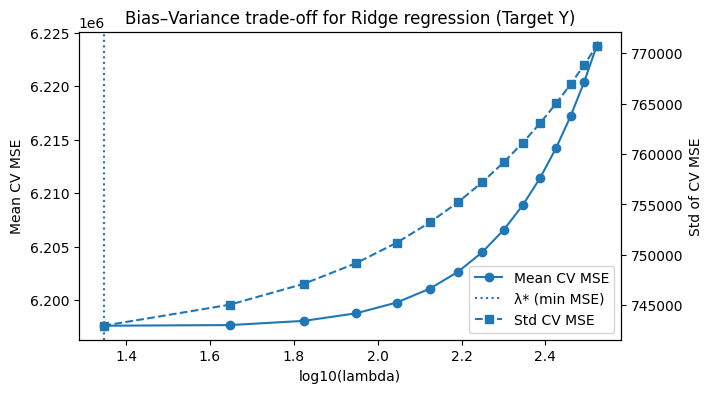

In [65]:
# Bias Variance - Ridge
lambdas = np.array(RIDGE_lam_grid_Y_r2)
x = np.log10(lambdas)

mean_mse = RIDGE_MSE_mean_th_r2[0]
std_mse  = RIDGE_MSE_std_th_r2[0]

fig, ax1 = plt.subplots(figsize=(7,4))

# Mean MSE (bias proxy)
ax1.plot(x, mean_mse, marker='o', label="Mean CV MSE")
ax1.set_xlabel("log10(lambda)")
ax1.set_ylabel("Mean CV MSE")

# Std MSE (variance proxy)
ax2 = ax1.twinx()
ax2.plot(x, std_mse, marker='s', linestyle='--', label="Std CV MSE")
ax2.set_ylabel("Std of CV MSE")

# Mark best lambda
RIDGE_best_h_Y_r2 = np.argmin(mean_mse)
ax1.axvline(x[RIDGE_best_h_Y_r2], linestyle=':', label="λ* (min MSE)")

# Legend (combined)
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="best")

plt.title("Bias–Variance trade-off for Ridge regression (Target Y)")
plt.show()


/var/folders/x7/qg3pwzcj4lq7gkhkzz_qd6c80000gn/T/ipykernel_11333/751240967.py:6: RuntimeWarning: divide by zero encountered in log10
  x = np.log10(lambdas)


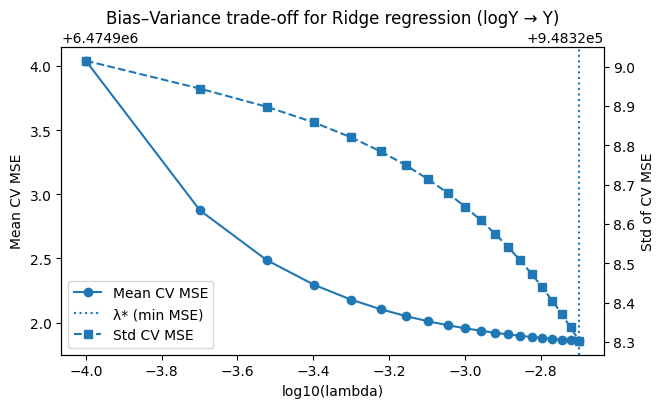

In [66]:
# Bias Variance plots for - Ridge log Y
mean_mse = RIDGE_MSE_mean_th_r2[1]
std_mse  = RIDGE_MSE_std_th_r2[1]

lambdas = np.array(RIDGE_lam_grid_lY_r2)
x = np.log10(lambdas)

fig, ax1 = plt.subplots(figsize=(7,4))

ax1.plot(x, mean_mse, marker='o', label="Mean CV MSE")
ax1.set_xlabel("log10(lambda)")
ax1.set_ylabel("Mean CV MSE")

ax2 = ax1.twinx()
ax2.plot(x, std_mse, marker='s', linestyle='--', label="Std CV MSE")
ax2.set_ylabel("Std of CV MSE")

RIDGE_best_h_lY_r2 = np.argmin(mean_mse)
ax1.axvline(x[RIDGE_best_h_lY_r2], linestyle=':', label="λ* (min MSE)")

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="best")

plt.title("Bias–Variance trade-off for Ridge regression (logY → Y)")
plt.show()


## RBF Kernel

>  Takes about 15 minutes on my PC


In [67]:
# Gave the best results, maybe the data has a radial nature
# Runs the Regressio model for a range of hyperparameters 2D grid (γ, λ), over the K folds - for Y ony // logY was adding too much transformation, better to Hyperparameter tune later


RBF_gam_grid = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 0.]
RBF_lam_grid = [1e-11, 1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5]

# (lambda, gamma, K-folds)
RBF_R2_lgk  = np.zeros((len(RBF_lam_grid),
                        len(RBF_gam_grid),
                        K))
RBF_MSE_lgk = np.zeros((len(RBF_lam_grid),
                        len(RBF_gam_grid),
                        K))

X_train_norm, X_row_of_means, X_row_of_stds = standardise(X_train)

for l in tqdm(range(len(RBF_lam_grid)), desc="Lambda"):
    for g in range(len(RBF_gam_grid)):
        for i in range(K):
            X_train_i, Y_train_i, X_val_i, Y_val_i = k_fold_indices(
                X_train_norm, Y_train, K, i
            )

            try:
                a_temp, r_temp = RBF_kernel_regression(
                    X_train_i,
                    Y_train_i,
                    RBF_gam_grid[g],
                    RBF_lam_grid[l],
                    ifPlot=False
                )

                yPred_temp = RBF_kernel_regression_predictor(
                    a_temp,
                    X_val_i,
                    X_train_i,
                    Y_val_i,
                    RBF_gam_grid[g],
                    ifPlot=False
                )

                RBF_MSE_lgk[l, g, i] = mse(Y_val_i, yPred_temp)
                RBF_R2_lgk[l, g, i]  = r2(Y_val_i, yPred_temp)

            except Exception as e:
                print(f"FAILED at lam={RBF_lam_grid[l]}, gam={RBF_gam_grid[g]}, fold={i}: {type(e).__name__}: {e}")
                RBF_MSE_lgk[l, g, i] = np.nan
                RBF_R2_lgk[l, g, i]  = np.nan


RBF_MSE_mean_lg = np.nanmean(RBF_MSE_lgk, axis=2)
RBF_MSE_std_lg  = np.nanstd(RBF_MSE_lgk, axis=2)

RBF_R2_mean_lg  = np.nanmean(RBF_R2_lgk, axis=2)
RBF_R2_std_lg   = np.nanstd(RBF_R2_lgk, axis=2)


Lambda: 100%|██████████| 7/7 [14:42<00:00, 126.11s/it]


Best R²        : 0.833701
Best gamma     : 1.00e-03
Best lambda    : 1.00e-06


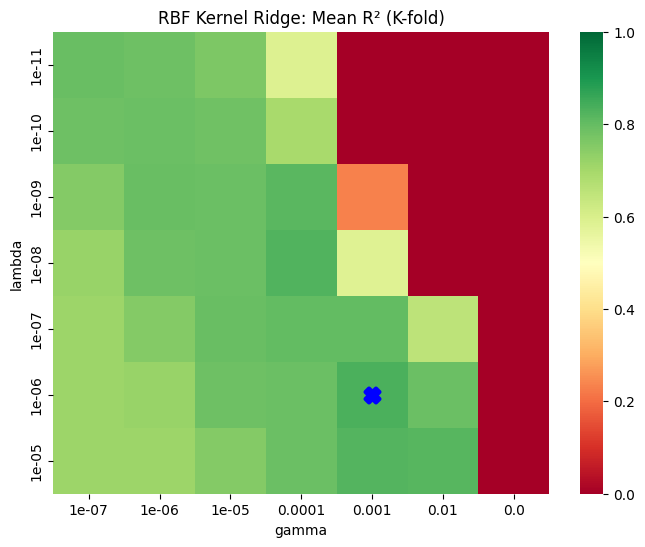

In [68]:
# A great Plot of the Grid search If I say so myself! 
# Shows the best spot I received a good fit in in teh grid of Hyperparameters considered

# ---------------------------------
# Spot marked with a Blue Cross !
# ---------------------------------

RBF_best_R2 = np.max(RBF_R2_mean_lg)
RBF_best_l, RBF_best_g = np.unravel_index(np.argmax(RBF_R2_mean_lg), RBF_R2_mean_lg.shape)

print(f"Best R²        : {RBF_best_R2:.6f}")
print(f"Best gamma     : {RBF_gam_grid[RBF_best_g]:.2e}")
print(f"Best lambda    : {RBF_lam_grid[RBF_best_l]:.2e}")
# print(f"Grid position  : (lambda idx={RBF_best_l}, gamma idx={RBF_best_g})")


plt.figure(figsize=(8, 6))

RBF_R2_mean_store_lg = RBF_R2_mean_lg
RBF_xtick_gam = RBF_gam_grid
RBF_ytick_lam = RBF_lam_grid

sns.heatmap(
    RBF_R2_mean_lg,
    xticklabels=RBF_gam_grid,
    yticklabels=RBF_lam_grid,
    cmap="RdYlGn",
    vmin=0.0,
    vmax=1.0,
    center=0.5,   # visual midpoint
    annot=False
)
plt.scatter(RBF_best_g + .5, RBF_best_l + .5, color='blue', s=100, marker='X', linewidths=3, label='Best R²')

plt.xlabel("gamma")
plt.ylabel("lambda")
plt.title("RBF Kernel Ridge: Mean R² (K-fold)")
plt.show()


## Lasso

In [69]:
# only optimise Lambda, as tau value is set to converge to optima already 
# Runs the Regressio model for a range of hyperparameters, over the K folds - for Y 

LASSO_lam_grid = [1e-5, 1e-4, 1e-3, 1e-2, 0.1, 1, 10, 1e2, 1e3, 1e4, 1e5, 1e6]


# (target, hyperparam, K-folds)
LASSO_R2_thk = np.zeros((2, len(LASSO_lam_grid), K))
LASSO_MSE_thk = np.zeros((2, len(LASSO_lam_grid), K))

X_train_norm, X_row_of_means, X_row_of_stds  = standardise(X_train)

for h in range(len(LASSO_lam_grid)):
    for i in range(K):
        # Y
        X_train_i, Y_train_i, X_val_i, Y_val_i = k_fold_indices(X_train_norm, Y_train, K, i)
    
        w_temp = lasso(X_train_i, Y_train_i, LASSO_lam_grid[h])
        yPred_temp = linear_regression_prediction(X_val_i, w_temp)

        LASSO_MSE_thk[0, h, i] = mse(Y_val_i, yPred_temp)
        LASSO_R2_thk[0, h, i] = r2(Y_val_i, yPred_temp)

       # logY
        X_train_i, logY_train_i, X_val_i, logY_val_i = k_fold_indices(X_train_norm, logY_train, K, i)

        w_temp = lasso(X_train_i, logY_train_i, LASSO_lam_grid[h])
        yPred_temp = linear_regression_prediction(X_val_i, w_temp)

        Y_val_temp = de_log_transform(logY_val_i)
        Ypred_val_temp = de_log_transform(yPred_temp)

        LASSO_MSE_thk[1, h, i] = mse(Y_val_temp, Ypred_val_temp)
        LASSO_R2_thk[1, h, i] = r2(Y_val_temp, Ypred_val_temp)
        

LASSO_MSE_mean_th = LASSO_MSE_thk.mean(axis=2)
LASSO_MSE_std_th  = LASSO_MSE_thk.std(axis=2)

LASSO_R2_mean_th  = LASSO_R2_thk.mean(axis=2)
LASSO_R2_std_th   = LASSO_R2_thk.std(axis=2)

# ------------------------------------------------------------

# Lasso Results
LASSO_best_h_Y  = np.argmax(LASSO_R2_mean_th[0])   # index in LASSO_lam_grid
LASSO_best_h_lY = np.argmax(LASSO_R2_mean_th[1])

LASSO_best_lam_Y  = LASSO_lam_grid[LASSO_best_h_Y]
LASSO_best_lam_lY = LASSO_lam_grid[LASSO_best_h_lY]

print("\nBest lambda for Y:", LASSO_best_lam_Y,
      "R2 mean:", LASSO_R2_mean_th[0, LASSO_best_h_Y],
      "std:", LASSO_R2_std_th[0, LASSO_best_h_Y])

print("Best lambda for logY->Y:", LASSO_best_lam_lY,
      "R2 mean:", LASSO_R2_mean_th[1, LASSO_best_h_lY],
      "std:", LASSO_R2_std_th[1, LASSO_best_h_lY])



Best lambda for Y: 10000.0 R2 mean: 0.7135458298394319 std: 0.025211547372202037
Best lambda for logY->Y: 10 R2 mean: 0.7035369369572114 std: 0.0239875061640328


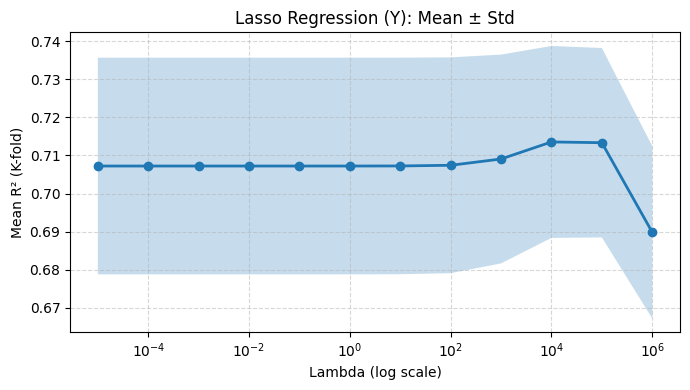

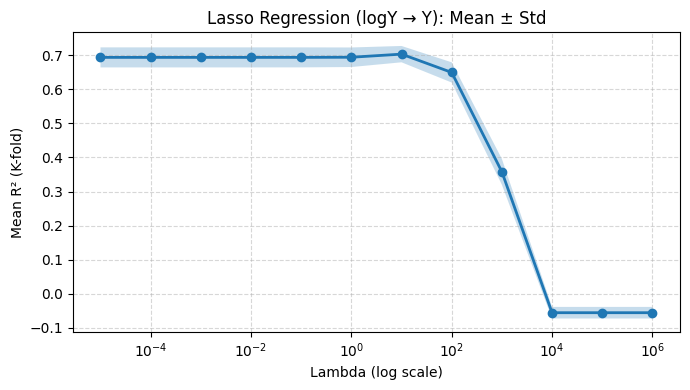

In [70]:
# Results (for Y and logY) plotted over Hyperparameter ranges

lambdas = np.array(LASSO_lam_grid)

plt.figure(figsize=(7, 4))

plt.plot(
    lambdas,
    LASSO_R2_mean_th[0],
    marker="o",
    linewidth=2
)

plt.fill_between(
    lambdas,
    LASSO_R2_mean_th[0] - LASSO_R2_std_th[0],
    LASSO_R2_mean_th[0] + LASSO_R2_std_th[0],
    alpha=0.25
)

plt.xscale("log")
plt.xlabel("Lambda (log scale)")
plt.ylabel("Mean R² (K-fold)")
plt.title("Lasso Regression (Y): Mean ± Std")
plt.grid(True, which="both", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


plt.figure(figsize=(7, 4))

plt.plot(
    lambdas,
    LASSO_R2_mean_th[1],
    marker="o",
    linewidth=2
)

plt.fill_between(
    lambdas,
    LASSO_R2_mean_th[1] - LASSO_R2_std_th[1],
    LASSO_R2_mean_th[1] + LASSO_R2_std_th[1],
    alpha=0.25
)

plt.xscale("log")
plt.xlabel("Lambda (log scale)")
plt.ylabel("Mean R² (K-fold)")
plt.title("Lasso Regression (logY → Y): Mean ± Std")
plt.grid(True, which="both", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


## NN

> takes about 9 minutes in my PC


(8002, 1)
(8002,)


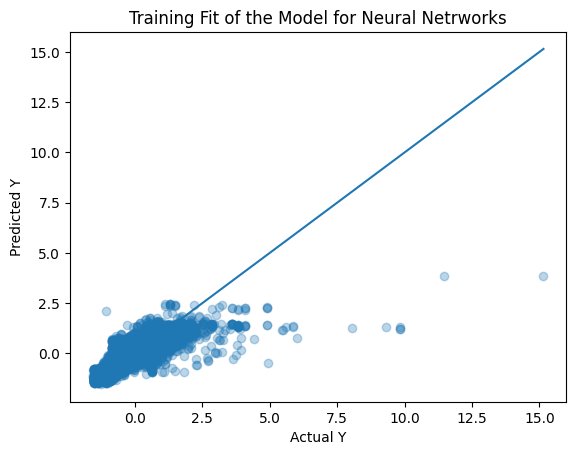

(8002, 1)
(8002,)


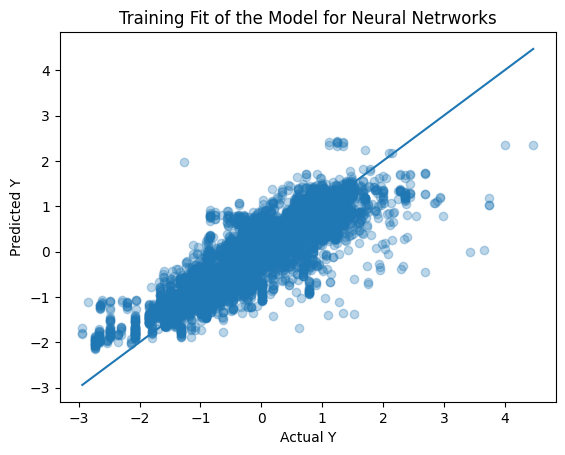

(8002, 1)
(8002,)


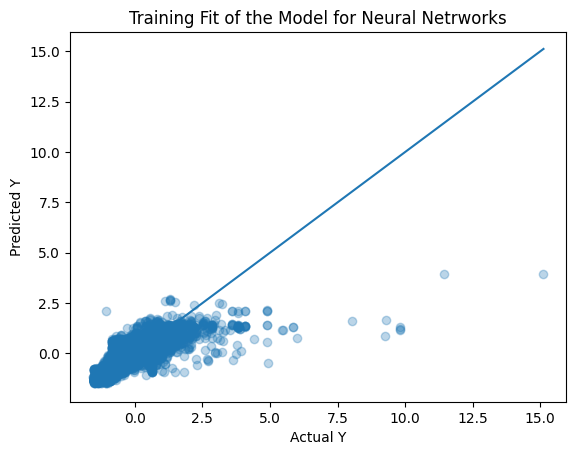

(8002, 1)
(8002,)


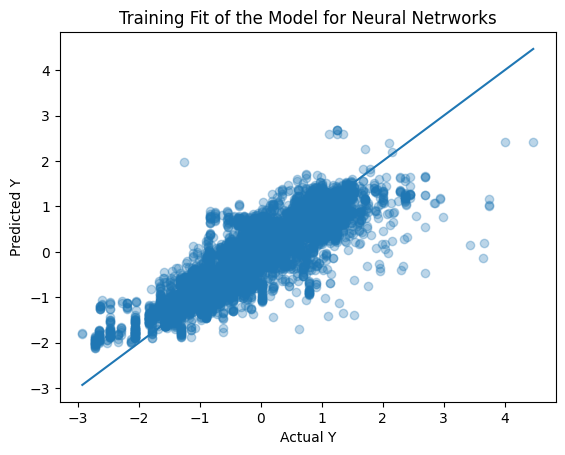

(8003, 1)
(8003,)


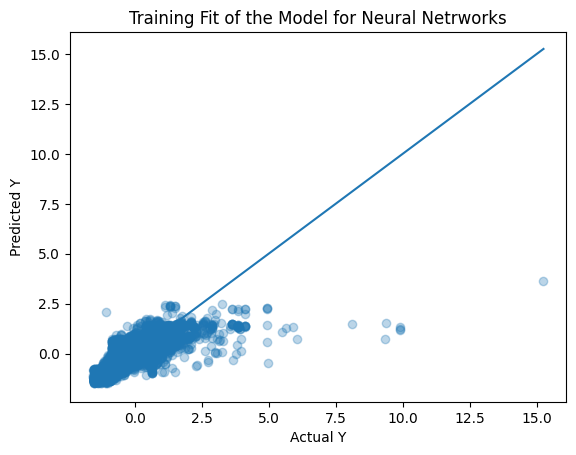

(8003, 1)
(8003,)


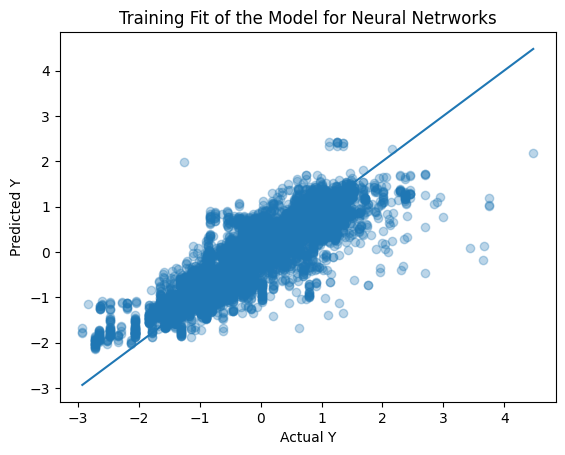

(8003, 1)
(8003,)


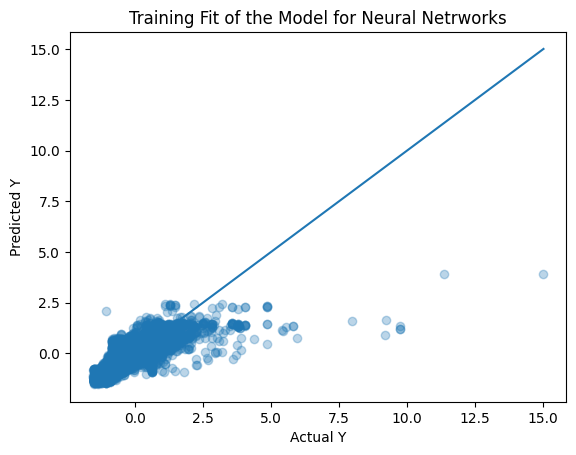

(8003, 1)
(8003,)


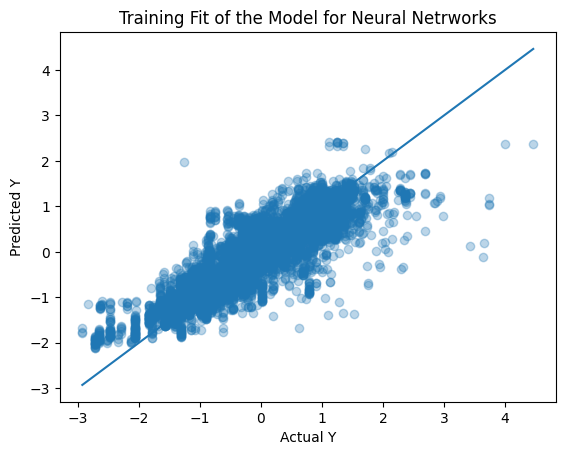

(8003, 1)
(8003,)


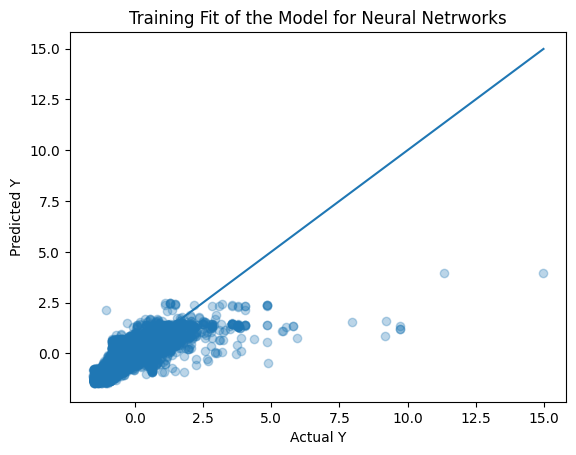

(8003, 1)
(8003,)


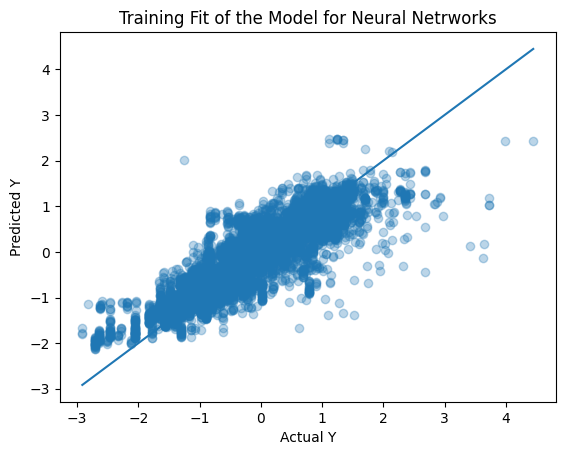

(8003, 1)
(8003,)


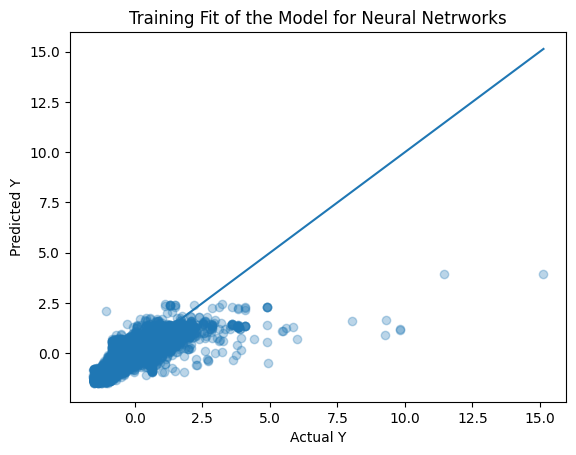

(8003, 1)
(8003,)


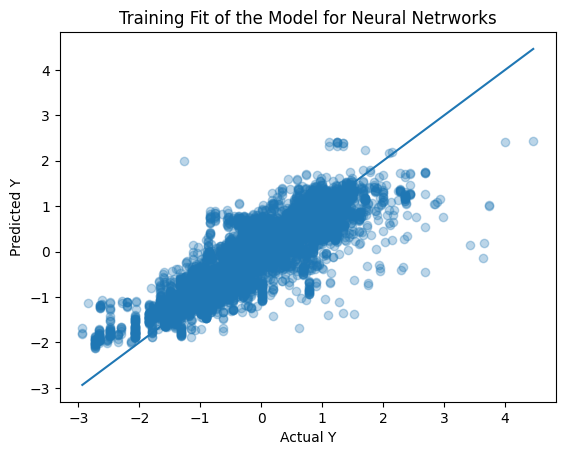

(8003, 1)
(8003,)


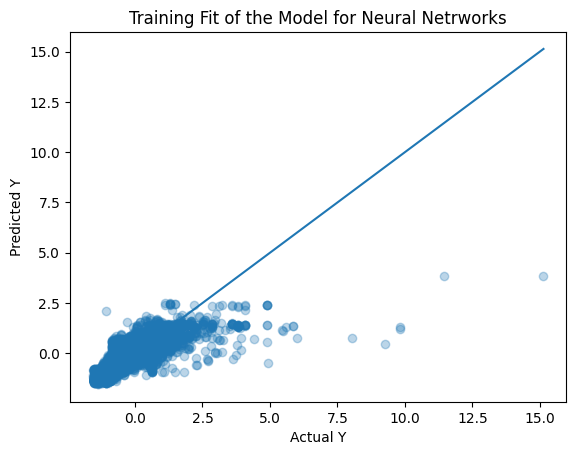

(8003, 1)
(8003,)


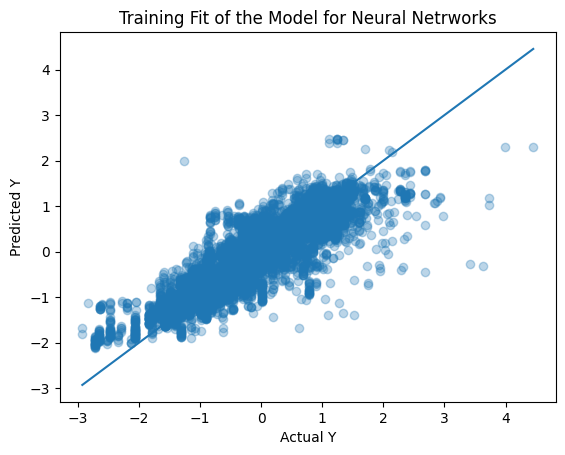

(8003, 1)
(8003,)


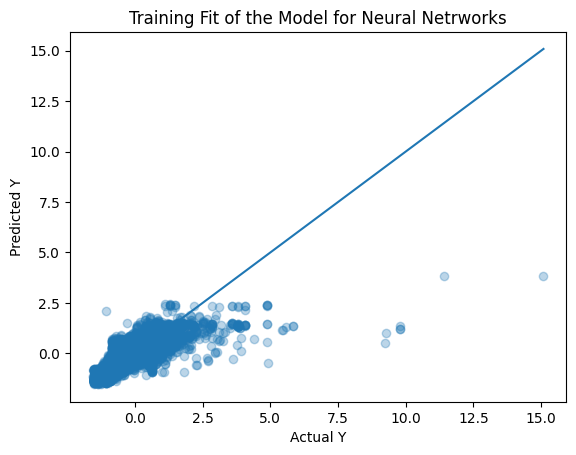

(8003, 1)
(8003,)


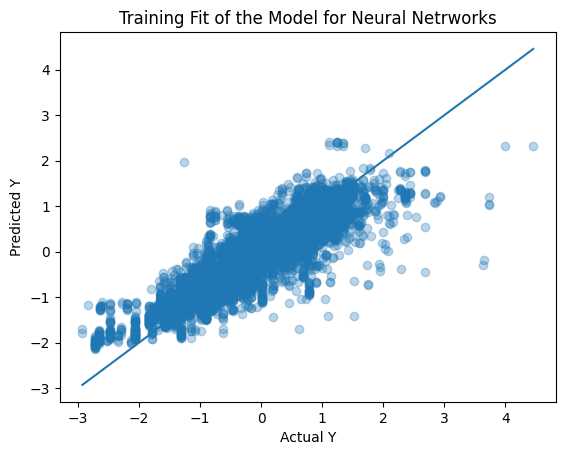

(8003, 1)
(8003,)


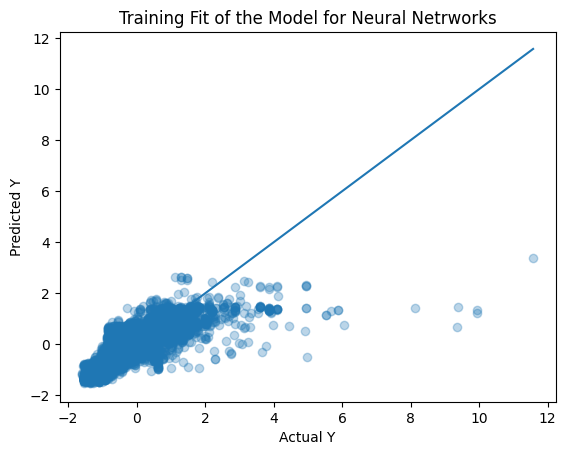

(8003, 1)
(8003,)


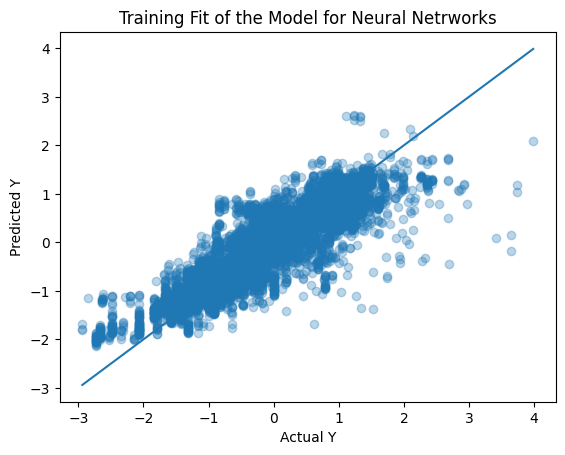

(8003, 1)
(8003,)


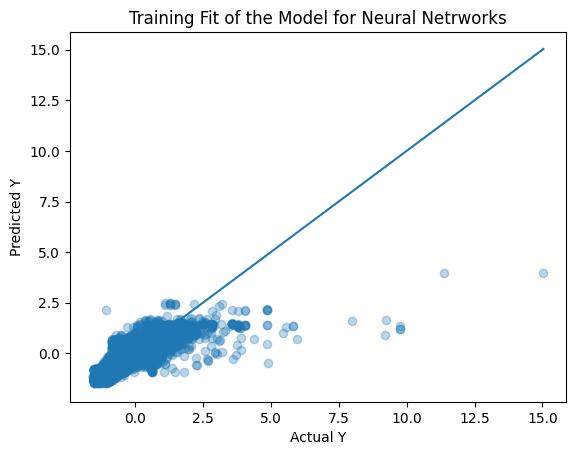

(8003, 1)
(8003,)


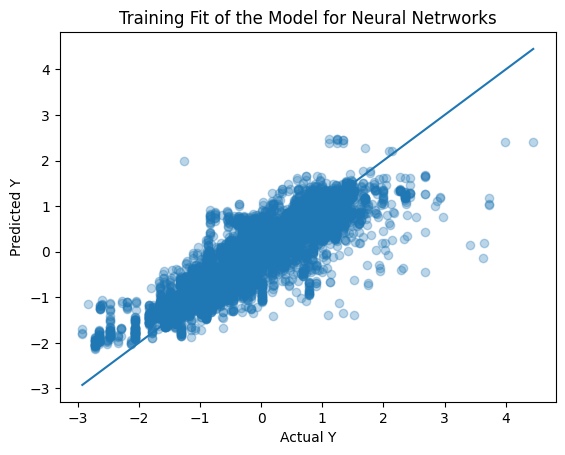

In [71]:
# only optimising Lambda, as tau value is set to converge to optima already 

##

# (target, K-folds)
NN_R2_tk = np.zeros((2, K))
NN_MSE_tk = np.zeros((2, K))

X_train_norm, X_row_of_means, X_row_of_stds  = standardise(X_train)

for i in range(K):
    X_train_i, Y_train_i, X_val_i, Y_val_i = k_fold_indices(X_train_norm, Y_train, K, i)
    Y_train_i_std, NN_row_means, NN_row_stds = standardise(Y_train_i)
    
    weightsNN, y_train_pred = Simple_NN(X_train_i, Y_train_i_std, hidden=128, lr=1e-3, n_iters=1000, ifPlot=True, seed=0, tanNotReLU = True)
    
    yPred_temp = NN_regression_predict(X_val_i, weightsNN)
    yPred_temp = de_standardise(yPred_temp, NN_row_means, NN_row_stds)

    NN_MSE_tk[0, i] = mse(Y_val_i, yPred_temp)
    NN_R2_tk[0, i] = r2(Y_val_i, yPred_temp)



    X_train_i, logY_train_i, X_val_i, logY_val_i = k_fold_indices(X_train_norm, logY_train, K, i)
    logY_train_i_std, NN_row_means, NN_row_stds = standardise(logY_train_i)


    weightsNN, y_train_pred = Simple_NN(X_train_i, logY_train_i_std, hidden=128, lr=1e-3, n_iters=1000, ifPlot=True, seed=0, tanNotReLU = True)
    yPred_temp = NN_regression_predict(X_val_i, weightsNN)
    yPred_temp = de_standardise(yPred_temp, NN_row_means, NN_row_stds)

    Y_val_temp = de_log_transform(logY_val_i)
    Ypred_val_temp = de_log_transform(yPred_temp)

    NN_MSE_tk[1, i] = mse(Y_val_temp, Ypred_val_temp)
    NN_R2_tk[1, i] = r2(Y_val_temp, Ypred_val_temp)
        

NN_MSE_mean_t = NN_MSE_tk.mean(axis=1)
NN_MSE_std_t  = NN_MSE_tk.std(axis=1)

NN_R2_mean_t  = NN_R2_tk.mean(axis=1)
NN_R2_std_t   = NN_R2_tk.std(axis=1)


In [72]:
print("\nNeural Network (K-fold CV results):")

print(
    f"Target Y:\n"
    f"  Mean MSE = {NN_MSE_mean_t[0]:.6f}  |  Std MSE = {NN_MSE_std_t[0]:.6f}\n"
    f"  Mean R²  = {NN_R2_mean_t[0]:.6f}  |  Std R²  = {NN_R2_std_t[0]:.6f}"
)

print(
    f"\nlogY → Y:\n"
    f"  Mean MSE = {NN_MSE_mean_t[1]:.6f}  |  Std MSE = {NN_MSE_std_t[1]:.6f}\n"
    f"  Mean R²  = {NN_R2_mean_t[1]:.6f}  |  Std R²  = {NN_R2_std_t[1]:.6f}"
)



Neural Network (K-fold CV results):
Target Y:
  Mean MSE = 7687032.364938  |  Std MSE = 1627441.612548
  Mean R²  = 0.648659  |  Std R²  = 0.041483

logY → Y:
  Mean MSE = 8443402.167868  |  Std MSE = 1802671.012992
  Mean R²  = 0.614261  |  Std R²  = 0.045933


# Visualisations:

## Validation Hyperparameter Tuning fits

In [73]:
# ---------------- Validation summary table ----------------

targets = ["Y", "logY → Y"]

def _safe_float(x):
    try:
        return float(x)
    except Exception:
        return np.nan

rows_val = []

# ---------- OLS (best normaliser ) ----------
norm_names = ["STD", "ROB", "LOGX", "MM"]

OLS_best_n_Y  = int(np.argmax(OLS_R2_mean_tn[0]))
OLS_best_n_lY = int(np.argmax(OLS_R2_mean_tn[1]))

for t, best_n in enumerate([OLS_best_n_Y, OLS_best_n_lY]):
    rows_val.append({
        "Model": "OLS",
        "Target": targets[t],
        "Best config": f"normaliser={norm_names[best_n]}",
        "R2_mean": _safe_float(OLS_R2_mean_tn[t, best_n]),
        "R2_std":  _safe_float(OLS_R2_std_tn[t, best_n]),
        "MSE_mean": _safe_float(OLS_MSE_mean_tn[t, best_n]),
        "MSE_std":  _safe_float(OLS_MSE_std_tn[t, best_n]),
    })

# ---------- Polynomial ----------
POLY_best_h_Y  = int(np.argmax(POLY_R2_mean_th[0]))
POLY_best_h_lY = int(np.argmax(POLY_R2_mean_th[1]))

for t, best_h in enumerate([POLY_best_h_Y, POLY_best_h_lY]):
    best_deg = POLY_deg_grid[best_h]
    rows_val.append({
        "Model": "POLY",
        "Target": targets[t],
        "Best config": f"degree={best_deg}",
        "R2_mean": _safe_float(POLY_R2_mean_th[t, best_h]),
        "R2_std":  _safe_float(POLY_R2_std_th[t, best_h]),
        "MSE_mean": _safe_float(POLY_MSE_mean_th[t, best_h]),
        "MSE_std":  _safe_float(POLY_MSE_std_th[t, best_h]),
    })

# ---------- Ridge (Round 2) ----------
RIDGE_best_h_Y_r2  = int(np.argmax(RIDGE_R2_mean_th_r2[0]))
RIDGE_best_h_lY_r2 = int(np.argmax(RIDGE_R2_mean_th_r2[1]))

RIDGE_best_lam_Y_r2  = RIDGE_lam_grid_Y_r2[RIDGE_best_h_Y_r2]
RIDGE_best_lam_lY_r2 = RIDGE_lam_grid_lY_r2[RIDGE_best_h_lY_r2]

for t, (best_h, best_lam) in enumerate([
    (RIDGE_best_h_Y_r2,  RIDGE_best_lam_Y_r2),
    (RIDGE_best_h_lY_r2, RIDGE_best_lam_lY_r2),
]):
    rows_val.append({
        "Model": "RIDGE",
        "Target": targets[t],
        "Best config": f"lambda={best_lam:.3e}",
        "R2_mean": _safe_float(RIDGE_R2_mean_th_r2[t, best_h]),
        "R2_std":  _safe_float(RIDGE_R2_std_th_r2[t, best_h]),
        "MSE_mean": _safe_float(RIDGE_MSE_mean_th_r2[t, best_h]),
        "MSE_std":  _safe_float(RIDGE_MSE_std_th_r2[t, best_h]),
    })

# ---------- Lasso ----------
LASSO_best_h_Y  = int(np.argmax(LASSO_R2_mean_th[0]))
LASSO_best_h_lY = int(np.argmax(LASSO_R2_mean_th[1]))

for t, best_h in enumerate([LASSO_best_h_Y, LASSO_best_h_lY]):
    best_lam = LASSO_lam_grid[best_h]
    rows_val.append({
        "Model": "LASSO",
        "Target": targets[t],
        "Best config": f"lambda={best_lam:.3e}",
        "R2_mean": _safe_float(LASSO_R2_mean_th[t, best_h]),
        "R2_std":  _safe_float(LASSO_R2_std_th[t, best_h]),
        "MSE_mean": _safe_float(LASSO_MSE_mean_th[t, best_h]),
        "MSE_std":  _safe_float(LASSO_MSE_std_th[t, best_h]),
    })

# ---------- RBF Kernel Ridge (single target Y in code) ----------
RBF_best_l, RBF_best_g = np.unravel_index(np.nanargmax(RBF_R2_mean_lg), RBF_R2_mean_lg.shape)
RBF_best_R2 = float(RBF_R2_mean_lg[RBF_best_l, RBF_best_g])

rows_val.append({
    "Model": "RBF-KRR",
    "Target": "Y",
    "Best config": f"lambda={RBF_lam_grid[RBF_best_l]:.3e}, gamma={RBF_gam_grid[RBF_best_g]:.3e}",
    "R2_mean": _safe_float(RBF_R2_mean_lg[RBF_best_l, RBF_best_g]),
    "R2_std":  _safe_float(RBF_R2_std_lg[RBF_best_l, RBF_best_g]),
    "MSE_mean": _safe_float(RBF_MSE_mean_lg[RBF_best_l, RBF_best_g]),
    "MSE_std":  _safe_float(RBF_MSE_std_lg[RBF_best_l, RBF_best_g]),
})

# ---------- NN ----------
rows_val.append({
    "Model": "NN",
    "Target": "Y",
    "Best config": "hidden=1028, lr=1e-3, iters=500, tanh",
    "R2_mean": _safe_float(NN_R2_mean_t[0]),
    "R2_std":  _safe_float(NN_R2_std_t[0]),
    "MSE_mean": _safe_float(NN_MSE_mean_t[0]),
    "MSE_std":  _safe_float(NN_MSE_std_t[0]),
})
rows_val.append({
    "Model": "NN",
    "Target": "logY → Y",
    "Best config": "hidden=1028, lr=1e-3, iters=500, tanh",
    "R2_mean": _safe_float(NN_R2_mean_t[1]),
    "R2_std":  _safe_float(NN_R2_std_t[1]),
    "MSE_mean": _safe_float(NN_MSE_mean_t[1]),
    "MSE_std":  _safe_float(NN_MSE_std_t[1]),
})

df_val = pd.DataFrame(rows_val)
df_val = df_val[["Model", "Target", "Best config", "R2_mean", "R2_std", "MSE_mean", "MSE_std"]]
df_val.sort_values(["Target", "R2_mean"], ascending=[True, False], inplace=True)

display(df_val)


,Model,Target,Best config,R2_mean,R2_std,MSE_mean,MSE_std
8,RBF-KRR,Y,"lambda=1.000e-06, gamma=1.000e-03",0.833701,0.034026,3.597004e+06,7.909029e+05
2,POLY,Y,degree=4,0.794993,0.022530,4.446811e+06,6.923455e+05
0,OLS,Y,normaliser=LOGX,0.750445,0.047201,5.415473e+06,1.200332e+06
6,LASSO,Y,lambda=1.000e+04,0.713546,0.025212,6.197089e+06,7.419825e+05
4,RIDGE,Y,lambda=4.440e+01,0.713544,0.025130,6.197665e+06,7.450488e+05
9,NN,Y,"hidden=1028, lr=1e-3, iters=500, tanh",0.648659,0.041483,7.687032e+06,1.627442e+06
1,OLS,logY → Y,normaliser=LOGX,0.762685,0.034401,5.136930e+06,8.711648e+05
3,POLY,logY → Y,degree=2,0.735473,0.024532,5.734698e+06,8.091827e+05
7,LASSO,logY → Y,lambda=1.000e+01,0.703537,0.023988,6.418887e+06,7.768097e+05
5,RIDGE,logY → Y,lambda=2.000e-03,0.701371,0.028903,6.474902e+06,9.483283e+05


## Testing

In [74]:
# Testing 
import numpy as np
import pandas as pd

# ---------------- Helpers: to apply normalisers ----------------
# here: only gives the standarsied values, no extras like means, IQR etc

def standardise_apply(X, row_means, row_stds):
    return (X - row_means) / row_stds

def robust_scale_apply(X, row_medians, safe_iqrs):
    return (X - row_medians) / safe_iqrs

def log_transform_apply(X, eps):
    return np.log(X + eps)

def minmax_normalise_apply(X, row_mins, safe_ranges):
    return (X - row_mins) / safe_ranges

# ---------------- Select best configs (reuse from Hyperparameter Tuning) ----------------

targets = ["Y", "logY → Y"]
norm_names = ["STD", "ROB", "LOGX", "MM"]

OLS_best_n_Y  = int(np.argmax(OLS_R2_mean_tn[0]))
OLS_best_n_lY = int(np.argmax(OLS_R2_mean_tn[1]))

POLY_best_h_Y  = int(np.argmax(POLY_R2_mean_th[0]))
POLY_best_h_lY = int(np.argmax(POLY_R2_mean_th[1]))

RIDGE_best_h_Y_r2  = int(np.argmax(RIDGE_R2_mean_th_r2[0]))
RIDGE_best_h_lY_r2 = int(np.argmax(RIDGE_R2_mean_th_r2[1]))
RIDGE_best_lam_Y_r2  = RIDGE_lam_grid_Y_r2[RIDGE_best_h_Y_r2]
RIDGE_best_lam_lY_r2 = RIDGE_lam_grid_lY_r2[RIDGE_best_h_lY_r2]

LASSO_best_h_Y  = int(np.argmax(LASSO_R2_mean_th[0]))
LASSO_best_h_lY = int(np.argmax(LASSO_R2_mean_th[1]))
LASSO_best_lam_Y  = LASSO_lam_grid[LASSO_best_h_Y]
LASSO_best_lam_lY = LASSO_lam_grid[LASSO_best_h_lY]

RBF_best_l, RBF_best_g = np.unravel_index(np.nanargmax(RBF_R2_mean_lg), RBF_R2_mean_lg.shape)
RBF_best_lam = RBF_lam_grid[RBF_best_l]
RBF_best_gam = RBF_gam_grid[RBF_best_g]

# ---------------- Test runs ----------------

rows_test = []

# --- OLS test ---
# adapting def to predict with test data
def _ols_fit_predict(Xtr, ytr, Xte):
    w_temp, r_temp = simple_linear_regression(Xtr, ytr, ifPlot=False)
    return linear_regression_prediction(Xte, w_temp, ifPlot=False)

for t, best_n in enumerate([OLS_best_n_Y, OLS_best_n_lY]):
    # Fit the chosen normaliser on full X_train, apply to X_train and X_test
    if best_n == 0:
        Xtr_n, X_row_of_means, X_row_of_stds = standardise(X_train)
        Xte_n = standardise_apply(X_test, X_row_of_means, X_row_of_stds)
    elif best_n == 1:
        Xtr_n, X_row_of_medians, X_safe_iqrs = robust_scale(X_train)
        Xte_n = robust_scale_apply(X_test, X_row_of_medians, X_safe_iqrs)
    elif best_n == 2:
        Xtr_n, X_eps = log_transform(X_train)
        Xte_n = log_transform_apply(X_test, X_eps)
    elif best_n == 3:
        Xtr_n, X_row_of_mins, X_safe_ranges = minmax_normalise(X_train)
        Xte_n = minmax_normalise_apply(X_test, X_row_of_mins, X_safe_ranges)

    if t == 0:
        yhat = _ols_fit_predict(Xtr_n, Y_train, Xte_n)
        mse_test = mse(Y_test, yhat)
        r2_test  = r2(Y_test, yhat)
    else:
        yhat_log = _ols_fit_predict(Xtr_n, logY_train, Xte_n)
        yhat = de_log_transform(yhat_log)  # compare on Y-scale
        mse_test = mse(Y_test, yhat)
        r2_test  = r2(Y_test, yhat)

    rows_test.append({
        "Model": "OLS",
        "Target": targets[t],
        "Best config": f"normaliser={norm_names[best_n]}",
        "R2_test": float(r2_test),
        "MSE_test": float(mse_test),
    })

# --- Polynomial test ---
def _poly_fit_predict(deg, ytr):
    Xtr_n, X_mu, X_sig = standardise(X_train)
    Xte_n = standardise_apply(X_test, X_mu, X_sig)
    Xtr_aug = polynomial_augment(Xtr_n, deg)
    Xte_aug = polynomial_augment(Xte_n, deg)
    w_temp, r_temp = simple_linear_regression(Xtr_aug, ytr, ifPlot=False)
    return linear_regression_prediction(Xte_aug, w_temp, ifPlot=False)

POLY_best_deg_Y  = POLY_deg_grid[POLY_best_h_Y]
POLY_best_deg_lY = POLY_deg_grid[POLY_best_h_lY]

yhat = _poly_fit_predict(POLY_best_deg_Y, Y_train)
rows_test.append({
    "Model": "POLY",
    "Target": "Y",
    "Best config": f"degree={POLY_best_deg_Y}",
    "R2_test": float(r2(Y_test, yhat)),
    "MSE_test": float(mse(Y_test, yhat)),
})

yhat_log = _poly_fit_predict(POLY_best_deg_lY, logY_train)
yhat = de_log_transform(yhat_log)
rows_test.append({
    "Model": "POLY",
    "Target": "logY → Y",
    "Best config": f"degree={POLY_best_deg_lY}",
    "R2_test": float(r2(Y_test, yhat)),
    "MSE_test": float(mse(Y_test, yhat)),
})

# --- Ridge test ---
def _ridge_fit_predict(lam, ytr):
    Xtr_n, X_mu, X_sig = standardise(X_train)
    Xte_n = standardise_apply(X_test, X_mu, X_sig)
    w_temp, r_temp = ridge_regression(Xtr_n, ytr, lam, ifPlot=False)
    return linear_regression_prediction(Xte_n, w_temp, ifPlot=False)

yhat = _ridge_fit_predict(RIDGE_best_lam_Y_r2, Y_train)
rows_test.append({
    "Model": "RIDGE",
    "Target": "Y",
    "Best config": f"lambda={RIDGE_best_lam_Y_r2:.3e}",
    "R2_test": float(r2(Y_test, yhat)),
    "MSE_test": float(mse(Y_test, yhat)),
})

yhat_log = _ridge_fit_predict(RIDGE_best_lam_lY_r2, logY_train)
yhat = de_log_transform(yhat_log)
rows_test.append({
    "Model": "RIDGE",
    "Target": "logY → Y",
    "Best config": f"lambda={RIDGE_best_lam_lY_r2:.3e}",
    "R2_test": float(r2(Y_test, yhat)),
    "MSE_test": float(mse(Y_test, yhat)),
})

# --- Lasso test ---
def _lasso_fit_predict(lam, ytr):
    Xtr_n, X_mu, X_sig = standardise(X_train)
    Xte_n = standardise_apply(X_test, X_mu, X_sig)
    w_temp = lasso(Xtr_n, ytr, lam)
    return linear_regression_prediction(Xte_n, w_temp)

yhat = _lasso_fit_predict(LASSO_best_lam_Y, Y_train)
rows_test.append({
    "Model": "LASSO",
    "Target": "Y",
    "Best config": f"lambda={LASSO_best_lam_Y:.3e}",
    "R2_test": float(r2(Y_test, yhat)),
    "MSE_test": float(mse(Y_test, yhat)),
})

yhat_log = _lasso_fit_predict(LASSO_best_lam_lY, logY_train)
yhat = de_log_transform(yhat_log)
rows_test.append({
    "Model": "LASSO",
    "Target": "logY → Y",
    "Best config": f"lambda={LASSO_best_lam_lY:.3e}",
    "R2_test": float(r2(Y_test, yhat)),
    "MSE_test": float(mse(Y_test, yhat)),
})

# --- RBF Kernel Ridge test (Y only) ---
Xtr_n, X_mu, X_sig = standardise(X_train)
Xte_n = standardise_apply(X_test, X_mu, X_sig)

a_temp, r_temp = RBF_kernel_regression(
    Xtr_n, Y_train, RBF_best_gam, RBF_best_lam, ifPlot=False
)

yhat = RBF_kernel_regression_predictor(
    a_temp, Xte_n, Xtr_n, Y_test, RBF_best_gam, ifPlot=False
)

rows_test.append({
    "Model": "RBF-KRR",
    "Target": "Y",
    "Best config": f"lambda={RBF_best_lam:.3e}, gamma={RBF_best_gam:.3e}",
    "R2_test": float(r2(Y_test, yhat)),
    "MSE_test": float(mse(Y_test, yhat)),
})

# --- NN test ---
Xtr_n, X_mu, X_sig = standardise(X_train)
Xte_n = standardise_apply(X_test, X_mu, X_sig)

# Target Y
Ytr_std, NN_row_means_Y, NN_row_stds_Y = standardise(Y_train)
weightsNN, y_train_pred = Simple_NN(
    Xtr_n, Ytr_std, hidden=1028, lr=1e-3, n_iters=500, ifPlot=False, seed=0, tanNotReLU=True
)
yhat_std = NN_regression_predict(Xte_n, weightsNN)
yhat = de_standardise(yhat_std, NN_row_means_Y, NN_row_stds_Y)

rows_test.append({
    "Model": "NN",
    "Target": "Y",
    "Best config": "hidden=1028, lr=1e-3, iters=500, tanh",
    "R2_test": float(r2(Y_test, yhat)),
    "MSE_test": float(mse(Y_test, yhat)),
})

# Target logY → Y
logYtr_std, NN_row_means_lY, NN_row_stds_lY = standardise(logY_train)
weightsNN, y_train_pred = Simple_NN(
    Xtr_n, logYtr_std, hidden=1028, lr=1e-3, n_iters=500, ifPlot=False, seed=0, tanNotReLU=True
)
yhat_log_std = NN_regression_predict(Xte_n, weightsNN)
yhat_log = de_standardise(yhat_log_std, NN_row_means_lY, NN_row_stds_lY)
yhat = de_log_transform(yhat_log)

rows_test.append({
    "Model": "NN",
    "Target": "logY → Y",
    "Best config": "hidden=1028, lr=1e-3, iters=500, tanh",
    "R2_test": float(r2(Y_test, yhat)),
    "MSE_test": float(mse(Y_test, yhat)),
})

# ---------------- Final test table ----------------

df_test = pd.DataFrame(rows_test)
df_test = df_test[["Model", "Target", "Best config", "R2_test", "MSE_test"]]
df_test.sort_values(["Target", "R2_test"], ascending=[True, False], inplace=True)

display(df_test)


(8892, 1)
(8892,)
(8892, 1)
(8892,)


,Model,Target,Best config,R2_test,MSE_test
8,RBF-KRR,Y,"lambda=1.000e-06, gamma=1.000e-03",0.843343,3.055854e+06
2,POLY,Y,degree=4,0.796038,3.978623e+06
0,OLS,Y,normaliser=LOGX,0.763463,4.614041e+06
4,RIDGE,Y,lambda=4.440e+01,0.705420,5.746266e+06
6,LASSO,Y,lambda=1.000e+04,0.705020,5.754065e+06
9,NN,Y,"hidden=1028, lr=1e-3, iters=500, tanh",0.661402,6.604910e+06
1,OLS,logY → Y,normaliser=LOGX,0.754741,4.784188e+06
3,POLY,logY → Y,degree=2,0.735163,5.166083e+06
7,LASSO,logY → Y,lambda=1.000e+01,0.701455,5.823618e+06
5,RIDGE,logY → Y,lambda=2.000e-03,0.700074,5.850543e+06


In [75]:
# --- RBF Kernel Ridge test (Y only) ---
Xtr_n, X_mu, X_sig = standardise(X_train)
Xte_n = standardise_apply(X_test, X_mu, X_sig)

a_temp, r_temp = RBF_kernel_regression(
    Xtr_n, Y_train, RBF_best_gam, RBF_best_lam, ifPlot=False
)

yhat = RBF_kernel_regression_predictor(
    a_temp, Xte_n, Xtr_n, Y_test, RBF_best_gam, ifPlot=False
)

rows_test.append({
    "Model": "RBF-KRR",
    "Target": "Y",
    "Best config": f"lambda={RBF_best_lam:.3e}, gamma={RBF_best_gam:.3e}",
    "R2_test": float(r2(Y_test, yhat)),
    "MSE_test": float(mse(Y_test, yhat)),
})



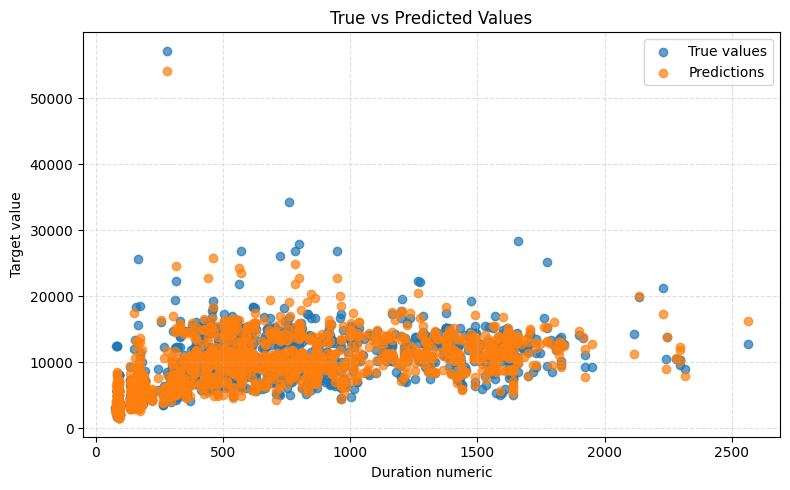

In [76]:
plt.figure(figsize=(8, 5))

plt.scatter(
    X_test[:, -10],
    Y_test,
    label="True values",
    alpha=0.7
)

plt.scatter(
    X_test[:, -10],
    yhat,
    label="Predictions",
    alpha=0.7
)

plt.xlabel(X_names_new[-10])  # "Duration numeric"
plt.ylabel("Target value")
plt.title("True vs Predicted Values")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.4)

plt.tight_layout()
plt.show()


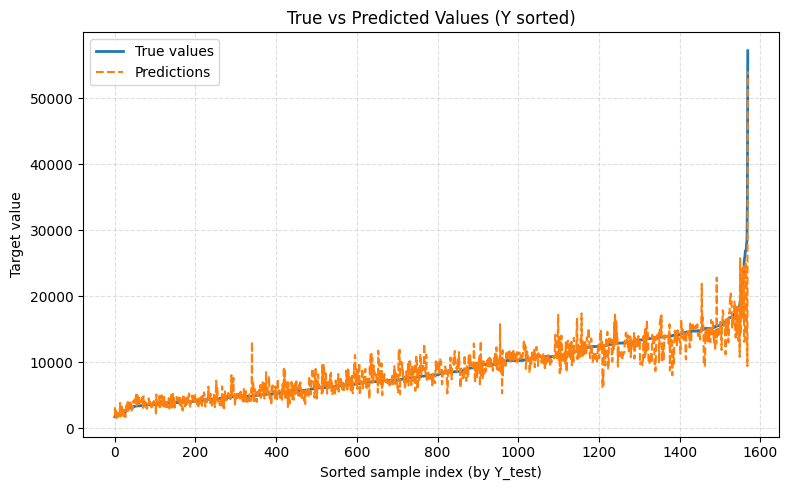

In [77]:

sorted_idx = np.argsort(Y_test)

# Sort true and predicted values
Y_sorted = Y_test[sorted_idx]
yhat_sorted = yhat[sorted_idx]

plt.figure(figsize=(8, 5))

plt.plot(Y_sorted, label="True values", linewidth=2)
plt.plot(yhat_sorted, label="Predictions", linestyle="--")

plt.xlabel("Sorted sample index (by Y_test)")
plt.ylabel("Target value")
plt.title("True vs Predicted Values (Y sorted)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.4)

plt.tight_layout()
plt.show()


## Weight to feature based comparison


=== FEATURE–TARGET CORRELATION (Y) ===
Top 5 strongest correlations:


,Feature,Correlation_with_Y,|Correlation|
63,Stops count,0.599162,0.599162
19,BOM,0.576835,0.576835
62,Duration numeric,0.496530,0.496530
4,Jet Airways,0.414805,0.414805
3,IndiGo,-0.353976,0.353976


Top 5 weakest correlations:


,Feature,Correlation_with_Y,|Correlation|
43,IXB,0.003624,0.003624
50,KNU,-0.002840,0.002840
41,TRV,0.001188,0.001188
59,IXA,0.000814,0.000814
11,Vistara Premium economy,-0.000366,0.000366


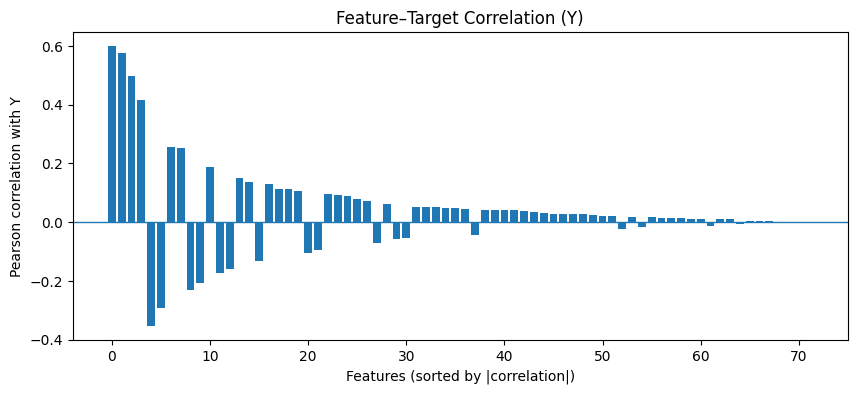

In [78]:
# ==================================
# FEATURE–TARGET CORRELATION (Y)
# ===================================


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Compute correlations (safe for constant columns)
corrs = []
for j in range(X_train.shape[1]):
    xj = X_train[:, j]
    if np.std(xj) == 0:
        corrs.append(0.0)
    else:
        corrs.append(np.corrcoef(xj, Y_train)[0, 1])

df_corr = pd.DataFrame({
    "Feature": X_names_new,
    "Correlation_with_Y": corrs,
    "|Correlation|": np.abs(corrs)
}).sort_values("|Correlation|", ascending=False)

# Show strongest and weakest
print("\n=== FEATURE–TARGET CORRELATION (Y) ===")
print("Top 5 strongest correlations:")
display(df_corr.head(5))

print("Top 5 weakest correlations:")
display(df_corr.tail(5))

# --------------------------------
# Plot: sorted correlations
# -------------------------------
plt.figure(figsize=(10,4))
plt.bar(range(len(df_corr)), df_corr["Correlation_with_Y"])
plt.axhline(0, linewidth=1)
plt.xlabel("Features (sorted by |correlation|)")
plt.ylabel("Pearson correlation with Y")
plt.title("Feature–Target Correlation (Y)")
plt.show()


In [79]:
# FINAL INTERPRETABILITY BLOCK

df_ols = df_test[df_test["Model"] == "OLS"]
best_ols_row = df_ols.loc[df_ols["R2_test"].idxmax()]

best_target = best_ols_row["Target"]          # "Y" or "logY → Y"
best_norm   = best_ols_row["Best config"].split("=")[-1]

norm_map = {"STD": 0, "ROB": 1, "LOGX": 2, "MM": 3}
best_n = norm_map[best_norm]

# Apply chosen normaliser
if best_n == 0:
    Xtr_n, mu, sig = standardise(X_train)
elif best_n == 1:
    Xtr_n, mu, sig = robust_scale(X_train)
elif best_n == 2:
    Xtr_n, eps = log_transform(X_train)
elif best_n == 3:
    Xtr_n, mu, sig = minmax_normalise(X_train)

# choose target
ytr = Y_train if best_target == "Y" else logY_train


w_ols, _ = simple_linear_regression(Xtr_n, ytr, ifPlot=False)

# drop intercept
w_feat = w_ols[1:]

df_ols_weights = pd.DataFrame({
    "Feature": X_names_new,
    "Weight": w_feat,
    "|Weight|": np.abs(w_feat)
})



print("\n=== OLS FEATURE INFLUENCE ===")
print("Interpretation: positive weight ↑ target, negative weight ↓ target (linear relation)")

nFeats = 10
# Top 5 most positive
df_ols_pos5 = df_ols_weights.sort_values("Weight", ascending=False).head(nFeats)

# Top 5 most negative
df_ols_neg5 = df_ols_weights.sort_values("Weight", ascending=True).head(nFeats)

print(f"\nTop {nFeats} MOST POSITIVE weights:")
display(df_ols_pos5[["Feature", "Weight", "|Weight|"]])

print(f"\nTop {nFeats} MOST NEGATIVE weights:")
display(df_ols_neg5[["Feature", "Weight", "|Weight|"]])


# 2) RBF FEATURE INFLUENCE
# Since the RBF kernel model has no explicit feature coefficients, feature influence is quantified-
# -using permutation importance, it's identified as the increase in test MSE after randomly permuting each feature.

def permutation_importance_rbf(Xtr, ytr, Xte, yte, gamma, lam, n_repeats=5):
    base_a, _ = RBF_kernel_regression(Xtr, ytr, gamma, lam, ifPlot=False)
    base_pred = RBF_kernel_regression_predictor(
        base_a, Xte, Xtr, yte, gamma, ifPlot=False
    )
    base_mse = mse(yte, base_pred)

    importances = np.zeros(Xte.shape[1])

    rng = np.random.default_rng(0)

    for j in range(Xte.shape[1]):
        delta = []
        for _ in range(n_repeats):
            Xte_perm = Xte.copy()
            rng.shuffle(Xte_perm[:, j])
            y_perm = RBF_kernel_regression_predictor(
                base_a, Xte_perm, Xtr, yte, gamma, ifPlot=False
            )
            delta.append(mse(yte, y_perm) - base_mse)
        importances[j] = np.mean(delta)

    return importances


# standardise (as you already did for RBF test)
Xtr_n, mu, sig = standardise(X_train)
Xte_n = standardise_apply(X_test, mu, sig)

rbf_importance = permutation_importance_rbf(
    Xtr_n, Y_train, Xte_n, Y_test,
    RBF_best_gam, RBF_best_lam
)

df_rbf_imp = pd.DataFrame({
    "Feature": X_names_new,
    "ΔMSE (perm)": rbf_importance,
    "|ΔMSE|": np.abs(rbf_importance)
}).sort_values("|ΔMSE|", ascending=False)

print("\n=== RBF FEATURE IMPORTANCE ===")
print("Interpretation: larger ΔMSE ⇒ feature more important (nonlinear reltion)")
display(df_rbf_imp.head(10))           # strongest
display(df_rbf_imp.tail(10))           # weakest



=== OLS FEATURE INFLUENCE ===
Interpretation: positive weight ↑ target, negative weight ↓ target (linear relation)

Top 10 MOST POSITIVE weights:


,Feature,Weight,|Weight|
5,Jet Airways Business,1078.177006,1078.177006
67,business class,673.136850,673.136850
58,JLR,533.094562,533.094562
45,IXU,429.488723,429.488723
55,DED,390.863354,390.863354
49,PAT,348.223952,348.223952
47,VNS,316.158987,316.158987
53,ISK,291.072445,291.072445
37,JDH,277.074548,277.074548
43,IXB,273.801385,273.801385



Top 10 MOST NEGATIVE weights:


,Feature,Weight,|Weight|
2,GoAir,-959.243813,959.243813
8,SpiceJet,-956.128286,956.128286
0,Air Asia,-942.418330,942.418330
9,Trujet,-940.896247,940.896247
3,IndiGo,-928.383178,928.383178
11,Vistara Premium economy,-913.881049,913.881049
1,Air India,-857.221690,857.221690
10,Vistara,-854.546657,854.546657
7,Multiple carriers Premium economy,-812.458102,812.458102
6,Multiple carriers,-806.975101,806.975101



=== RBF FEATURE IMPORTANCE ===
Interpretation: larger ΔMSE ⇒ feature more important (nonlinear reltion)


,Feature,ΔMSE (perm),|ΔMSE|
12,Date-numeric,2.597872e+07,2.597872e+07
14,Banglore,2.555368e+07,2.555368e+07
62,Duration numeric,1.714671e+07,1.714671e+07
16,Delhi,1.139409e+07,1.139409e+07
17,Kolkata,5.989781e+06,5.989781e+06
4,Jet Airways,4.989047e+06,4.989047e+06
19,BOM,4.715430e+06,4.715430e+06
61,Arrival time numeric,4.504772e+06,4.504772e+06
63,Stops count,4.442501e+06,4.442501e+06
69,in-flight meal not included,3.599488e+06,3.599488e+06


,Feature,ΔMSE (perm),|ΔMSE|
9,Trujet,0.0,0.0
47,VNS,0.0,0.0
59,IXA,0.0,0.0
46,IXC,0.0,0.0
58,JLR,0.0,0.0
57,IXZ,0.0,0.0
54,VTZ,0.0,0.0
52,IMF,0.0,0.0
49,PAT,0.0,0.0
71,red-eye flight,0.0,0.0


# Total Time elapsed 
> Note: make sense only for a continuous run

In [80]:
# ---------------- Runtime timer: END ----------------
_t_end = time.time()
_total_seconds = _t_end - _t_start

hours   = int(_total_seconds // 3600)
minutes = int((_total_seconds % 3600) // 60)
seconds = _total_seconds % 60

print("\n================ Total Runtime ================")
print(f"Elapsed time: {hours}h {minutes}m {seconds:.2f}s")
print("==============================================")
# ----------------------------------------------------



================ Total Runtime ================
Elapsed time: 0h 18m 11.00s
